In [31]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator

method_path = "figs/QSSA/SIM_results/"
mechanism_name = "NH3_otomo"

case_name = "case_NH3_counterflow_KAUST"

color_arr = ('k','r','b','y','g', 'c','m')
symbol_arr = ('s','o','v','^','*')
# ─── Use generic serif font ───────────────────────────────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 7
plt.rcParams["axes.linewidth"] = 0.3   # thinner borders
plt.rcParams["xtick.major.width"] = 0.3
plt.rcParams["ytick.major.width"] = 0.3
plt.rcParams["xtick.minor.width"] = 0.2
plt.rcParams["ytick.minor.width"] = 0.2

# Figure 1: Plot the validation plot

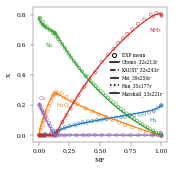

→ Saved combined plot at: figs/validation/validation_all_species.pdf


In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator    # ← import this

# ─── User‐adjustable settings ──────────────────────────────────────────────────

# 1) Where your EXPERIMENTAL CSVs live (each two‐column, no header):
exp_dir = "EXP_data/exp"

# 2) Root of all SIMULATION folders:
method_path = "SIM_results"

# 3) Which “case_name” subfolder to look under:
case_name = "case_NH3_counterflow_KAUST"

# 4) The list of mechanism‐folder names you want to compare:
mechanisms = [
    "Otomo_32s213r",
    "KAUST_32s243r",
    "Mei_39s256r",
    "Han_35s177r",
    "Marshall_33s221r"
]

# 5) The list of your target_cases (same as when you ran QSSA):
target_case_assemble = [
    "N_CF_1",
]

# 6) Colors to cycle through for each species (Tableau “tab:” palette):
color_arr = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink'
]

# 7) Marker symbols to cycle through for each mechanism:
symbol_arr = ['s', '^', 'v', '*', 'D', 'X']

# 8) Line styles to cycle through for each mechanism (only three as requested)
line_arr = ['-', '--', '-.', ':']

# 9) Dictionary of manual text offsets (dx, dy) for each species.
text_offsets = {
    "H2":   (0.9,  0.1),
    "H2O":  (0.14, 0.2),
    "N2":   (0.05, -0.18),
    "NH3":  (0.9,  0.7),
    "O2":   (-0.01, 0.04),
}

species_labels = {
    "NH3": r"$\mathrm{NH}_3$",
    "H2":  r"$\mathrm{H}_2$",
    "H2O": r"$\mathrm{H}_2\mathrm{O}$",
    "N2":  r"$\mathrm{N}_2$",
    "O2":  r"$\mathrm{O}_2$",
}


# 10) Where to dump the combined validation PDF:
output_dir = "figs/validation"
os.makedirs(output_dir, exist_ok=True)


def read_two_column_csv(path):
    return pd.read_csv(path, header=None, names=["x", "y"])


species_list = []
for fname in sorted(os.listdir(exp_dir)):
    if not fname.lower().endswith(".csv"):
        continue
    name = fname[:-4]
    if name.upper() == "T":
        continue
    species_list.append(name)

if not species_list:
    raise RuntimeError("No experimental species files found.")


plt.figure(figsize=(2.367, 2.3))


for i, species in enumerate(species_list):
    color = color_arr[i % len(color_arr)]
    exp_path = os.path.join(exp_dir, f"{species}.csv")
    try:
        df_exp = read_two_column_csv(exp_path).sort_values("x")
    except:
        continue

    plt.scatter(
        df_exp["x"], df_exp["y"],
        facecolors="none", edgecolors=color,
        linewidth=0.6, s=10, alpha=0.8, marker="o"
    )

    last_x = last_y = None

    for j, mech in enumerate(mechanisms):
        sim_marker    = symbol_arr[j % len(symbol_arr)]
        sim_linestyle = line_arr[j % len(line_arr)]
        for tc in target_case_assemble:
            qssa_path = os.path.join(method_path, case_name, mech, f"{tc}.csv")
            if not os.path.isfile(qssa_path):
                continue

            df_qssa = pd.read_csv(qssa_path)
            ycol = f"X_{species}"
            if ycol not in df_qssa or "MF" not in df_qssa:
                continue

            x_values = df_qssa["MF"]
            y_values = df_qssa[ycol]

            plt.plot(
                x_values, y_values,
                color=color, linewidth=0.6, alpha=0.9,
                marker=sim_marker, markerfacecolor="none",
                markeredgecolor=color, markeredgewidth=0.1,
                linestyle=sim_linestyle, markersize=3,
                markevery=max(len(x_values)//20, 1)
            )
            if len(x_values):
                last_x, last_y = x_values.values[-1], y_values.values[-1]

    if last_x is not None:
        dx, dy = text_offsets.get(species, (0.02, 0.0))
        plt.text(
            last_x + dx, last_y + dy,
            species_labels[species], color=color,
            fontsize=6, va='center', ha='left'
        )


# ─── Legend proxies ───────────────────────────────────────────────────────────
exp_handle = Line2D([0],[0],
    color='k', marker='o',
    markerfacecolor="none",
    markeredgecolor="k",
    linestyle="None",
    markersize=4,
    label='EXP mean'
)

mech_handles = [exp_handle]
for j, mech in enumerate(mechanisms):
    sim_marker    = symbol_arr[j % len(symbol_arr)]
    sim_linestyle = line_arr[j % len(line_arr)]
    h = Line2D([0],[0],
        color="k", marker=sim_marker,
        markerfacecolor="none",
        markeredgecolor="k",
        markeredgewidth=0.1,
        linestyle=sim_linestyle,
        markersize=4,
        label=mech
    )
    mech_handles.append(h)


# ─── Final formatting ───────────────────────────────────────────────────────────
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.xlabel("MF", fontsize=6)
plt.ylabel("X", fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=6)

plt.legend(handles=mech_handles,
           fontsize=4.5, loc="best",
           ncol=1, framealpha=0)

plt.tight_layout(pad=0.8)
out_file = os.path.join(output_dir, "validation_all_species.pdf")
plt.savefig(out_file, dpi=300)
plt.show()
print(f"→ Saved combined plot at: {out_file}")

# Figure 2: Plot comparison of Mechanism :
 Zst = 0.10932384533379182
## 后续考虑加上Zst line

<ipython-input-19-0903d6385276>:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.6)


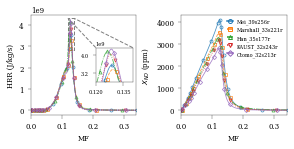

→ Saved small HRR / NO figure with zoom at: figs/validation/sim_HRR_and_NO_small_with_zoom.pdf


In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import MaxNLocator  # ← needed for reducing tick numbers

# ─── Use generic serif font and set base font size to 6 ────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 7

# ─── User‐adjustable settings ──────────────────────────────────────────────────

# 1) Root of all SIMULATION folders:
method_path = "SIM_results"

# 2) Which “case_name” subfolder to look under:
case_name = "case_NH3_counterflow_KAUST"

# 3) The list of mechanism‐folder names you want to compare:
mechanisms = [
    "Mei_39s256r",
    "Marshall_33s221r",
    "Han_35s177r",
    "KAUST_32s243r",
    "Otomo_32s213r",
]

# 4) The single target_case to use:
target_case = "N_CF_1"

# 5) Marker symbols to cycle through for each mechanism:
symbol_arr = ['o', 's', '^', 'v', 'D']

# 6) Colors to cycle through for each mechanism (Tableau “tab:” palette):
color_arr = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
]

# 7) Line styles to cycle through for each mechanism:
line_arr = ['-', '--', '-.', ':']

# 8) Where to dump the figure:
output_dir = "figs/validation"
os.makedirs(output_dir, exist_ok=True)


# ─── Prepare 2×1 subplot (width = 192 pt ≈ 2.667 in) ──────────────────────────
fig, (ax_left, ax_right) = plt.subplots(
    1, 2,
    figsize=(4, 2),
    sharex=True
)

# Plot HRR on the left and NO on the right
for j, mech in enumerate(mechanisms):
    mech_color     = color_arr[j % len(color_arr)]
    mech_marker    = symbol_arr[j % len(symbol_arr)]
    mech_linestyle = line_arr[j % len(line_arr)]

    sim_path = os.path.join(
        method_path, case_name, mech, f"{target_case}.csv"
    )
    if not os.path.isfile(sim_path):
        continue

    df_sim = pd.read_csv(sim_path)
    if "MF" not in df_sim.columns:
        continue

    x_vals = df_sim["MF"]

    # ─── Left subplot: HRR only ────────────────────────────────────────────────
    if "HRR" in df_sim.columns:
        y_hrr = df_sim["HRR"]
        ax_left.plot(
            x_vals,
            y_hrr,
            color=mech_color,
            linewidth=0.8,
            alpha=0.8,
            marker=mech_marker,
            markerfacecolor="none",
            markeredgecolor=mech_color,
            markeredgewidth=0.8,
            linestyle=mech_linestyle,
            markersize=3,
            markevery=max(len(x_vals)//20, 1),
            label=""  # no label here
        )

    # ─── Right subplot: X_NO * 1e6 (ppm) ──────────────────────────────────────
    if "X_NO" in df_sim.columns:
        y_no = df_sim["X_NO"] * 1e6
        ax_right.plot(
            x_vals,
            y_no,
            color=mech_color,
            linewidth=0.8,
            alpha=0.8,
            marker=mech_marker,
            markerfacecolor="none",
            markeredgecolor=mech_color,
            markeredgewidth=0.8,
            linestyle=mech_linestyle,
            markersize=3,
            markevery=max(len(x_vals)//20, 1),
            label=""  # no label here
        )


# ─── Add inset zoom on HRR (MF between 0.12 and 0.145, HRR between 2.8e9 and 3.9e9) ─
axins = inset_axes(
    ax_left,
    width="35%",
    height="35%",
    loc="center right",
    borderpad=0.5
)
for j, mech in enumerate(mechanisms):
    mech_color     = color_arr[j % len(color_arr)]
    mech_marker    = symbol_arr[j % len(symbol_arr)]
    mech_linestyle = line_arr[j % len(line_arr)]

    sim_path = os.path.join(
        method_path, case_name, mech, f"{target_case}.csv"
    )
    if not os.path.isfile(sim_path):
        continue

    df_sim = pd.read_csv(sim_path)
    if "MF" not in df_sim.columns or "HRR" not in df_sim.columns:
        continue

    x_vals = df_sim["MF"]
    y_hrr = df_sim["HRR"]

    axins.plot(
        x_vals,
        y_hrr,
        color=mech_color,
        linewidth=0.8,
        alpha=0.8,
        marker=mech_marker,
        markerfacecolor="none",
        markeredgecolor=mech_color,
        markeredgewidth=0.8,
        linestyle=mech_linestyle,
        markersize=3,
        markevery=max(len(x_vals)//20, 1)
    )

# Set zoomed‐in limits
axins.set_xlim(0.12, 0.14)
axins.set_ylim(2.8e9, 4.3e9)

# Reduce number of ticks to at most 3 on each axis
axins.xaxis.set_major_locator(MaxNLocator(nbins=2))
axins.yaxis.set_major_locator(MaxNLocator(nbins=2))

axins.yaxis.get_offset_text().set_fontsize(5)   # or whatever size you like
axins.xaxis.get_offset_text().set_fontsize(5) 

# Reduce the font size of these tick labels
axins.tick_params(axis='both', which='major', labelsize=5)

# Draw dashed connectors instead of solid
mark_inset(
    ax_left,
    axins,
    loc1=2,
    loc2=1,
    fc="none",
    ec="0.5",
    ls="--"  # ← dashed connector lines
)


ax_left.set_xlabel("MF", fontsize=7)
ax_right.set_xlabel("MF", fontsize=7)

ax_left.set_ylabel("HRR (J/kg/s)", fontsize=7)
ax_left.tick_params(axis='both', which='major', labelsize=7)
ax_left.set_xlim(0, 0.34)

ax_right.set_ylabel(r"$X_{NO}$ (ppm)", fontsize=7)
ax_right.tick_params(axis='both', which='major', labelsize=7)
ax_right.set_xlim(0, 0.34)


# ─── Build legend inside right subplot ─────────────────────────────────────────
legend_handles = []
for j, mech in enumerate(mechanisms):
    mech_color     = color_arr[j % len(color_arr)]
    mech_marker    = symbol_arr[j % len(symbol_arr)]
    mech_linestyle = line_arr[j % len(line_arr)]
    h = Line2D(
        [0], [0],
        color=mech_color,
        marker=mech_marker,
        markerfacecolor="none",
        markeredgecolor=mech_color,
        linestyle=mech_linestyle,
        markersize=4,
        label=mech
    )
    legend_handles.append(h)

ax_right.legend(
    handles=legend_handles,
    fontsize=5,
    loc="upper right",
    framealpha=0,
    borderpad=0.2,
    handlelength=1.2
)

plt.tight_layout(pad=0.6)

# ─── Save figure ───────────────────────────────────────────────────────────────
out_file = os.path.join(output_dir, "sim_HRR_and_NO_small_with_zoom.pdf")
plt.savefig(out_file, dpi=300)
plt.show()
plt.close()

print(f"→ Saved small HRR / NO figure with zoom at: {out_file}")

# Figure 3 Effect of mechanism on the reconstruction 

mechanisms = [
    "Otomo_32s213r",
    # "KAUST_32s243r",
    # "Mei_39s256r",
    "Han_35s177r",
    # "Marshall_33s221r"
]

 Zst = 0.10932384533379182
## 后续考虑加上Zst line

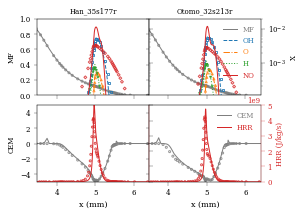

→ Saved figure at: figs/validation/1D_CEQ_NH3_combine_expanded_comparison.pdf


In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection

# ─── Use generic serif font and base font size 6 ──────────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 7

# ─── User‐adjustable settings ─────────────────────────────────────────────────
data_path   = "SIM_results"
case_folder = "case_NH3_counterflow_KAUST"
mechanisms  = [
    "Han_35s177r",
    "Otomo_32s213r",
]
title_names = ["Han_35s177r", "Otomo_32s213r"]
target_case = "N_CF_1"
xlim        = [3.5, 6.4]

cols_1 = ['MF', 'X_OH', 'X_O', 'X_H', 'X_NO']
cols_3 = ['CEM', 'HRR']

# ─── Use the Tableau “tab” colors ──────────────────────────────────────────────
symbol_arr = ['o', 's', '^', 'v', 'D']
color_arr  = ['tab:gray','tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
line_arr   = ['-', '--', '-.', ':', '-']

# specific tab‐colors for bottom‐row metrics
c_cem = 'tab:gray'
c_hrr = 'tab:red'

output_dir = "figs/validation"
os.makedirs(output_dir, exist_ok=True)

# ─── y‐limits ─────────────────────────────────────────────────────────────────
ylims_top    = {
    'MF':   (0.0, 1.0),
    'X_OH': (1.1e-4, 2e-2),
    'X_O':  (1.1e-4, 2e-2),
    'X_H':  (1.1e-4, 2e-2),
    'X_NO': (1.1e-4, 2e-2),
}
ylims_middle = {
    'CEM': (-5, 5),
    'HRR': (0, 5e9),
}

# ─── Build figure ─────────────────────────────────────────────────────────────
n = len(mechanisms)
fig, axs = plt.subplots(
    2, n,
    figsize=(2 * n, 3),
    sharex=True
)
if n == 1:
    axs = axs[:, np.newaxis]

for j, mech in enumerate(mechanisms):
    ax_top   = axs[0, j]
    ax_top_r = ax_top.twinx()
    ax_mid   = axs[1, j]
    ax_mid_r = ax_mid.twinx()

    ax_top.set_title(title_names[j], fontsize=7)

    # --- read SIM
    sim_csv = os.path.join(data_path, case_folder, mech, f"{target_case}.csv")
    df_sim  = pd.read_csv(sim_csv)
    grid    = df_sim['grid'] * 1000  # mm

    # --- read QSSA
    qssa_csv = os.path.join(
        "figs", "QSSA", data_path, case_folder,
        target_case, mech, "predicted_X.csv"
    )
    df_qssa = pd.read_csv(qssa_csv) if os.path.isfile(qssa_csv) else pd.DataFrame()

    # ─── Top row: MF + radicals ────────────────────────────────────────────────
    for i, col in enumerate(cols_1):
        mkr, ls, c = symbol_arr[i], line_arr[i], color_arr[i]
        lbl = col.replace("X_", "")

        ax = ax_top if col == 'MF' else ax_top_r
        # SIM scatter (hollow)
        if col in df_sim:
            ax.scatter(
                grid[::3], df_sim[col][::3],
                s=4, alpha=0.8,
                marker=mkr,
                facecolors='none',
                edgecolors=c
            )
        # QSSA line
        if col in df_qssa:
            ax.plot(
                grid, df_qssa[col],
                linestyle=ls,
                linewidth=1,
                color=c,
                label=lbl
            )

    # unify axes
    ax_top .set_xlim(xlim)
    ax_top .set_ylim(ylims_top['MF'])
    ax_top_r.set_xlim(xlim)
    ax_top_r.set_yscale('log')
    lo, hi = ylims_top['X_OH']
    ax_top_r.set_ylim((max(lo,1e-8), hi))

    # left y only first col
    if j == 0:
        ax_top.set_ylabel('MF', fontsize=7)
        ax_top.tick_params(labelleft=True)
    else:
        ax_top.tick_params(labelleft=False)

    # right y + legend last col
    if j == n - 1:
        ax_top_r.set_ylabel('X', fontsize=7)
        ax_top_r.tick_params(labelright=True)
        h1, l1 = ax_top.get_legend_handles_labels()
        h2, l2 = ax_top_r.get_legend_handles_labels()
        lg = ax_top_r.legend(
            h1 + h2, l1 + l2,
            loc='upper right', frameon=False, fontsize=7
        )
        for text, handle in zip(lg.get_texts(), lg.legend_handles):
            if isinstance(handle, Line2D):
                col_text = handle.get_color()
            elif isinstance(handle, PathCollection):
                ec = handle.get_edgecolor()
                col_text = ec[0] if len(ec)>0 else 'k'
            else:
                fc = handle.get_facecolor()
                col_text = fc[0] if len(fc)>0 else 'k'
            text.set_color(col_text)
    else:
        ax_top_r.tick_params(labelright=False)
    ax_top.tick_params(labelbottom=False)


    # ─── Bottom row: CEM + HRR ────────────────────────────────────────────────
    handles, labels = [], []

    # CEM: hollow scatter + tab:gray line
    if 'CEM' in df_sim:
        h_cem = ax_mid.scatter(
            grid[::3], df_sim['CEM'][::3],
            s=4, alpha=0.8,
            marker='o',
            facecolors='none',
            edgecolors=c_cem
        )
    if 'CEM' in df_qssa:
        cem_line, = ax_mid.plot(
            grid, df_qssa['CEM'],
            linestyle='-', linewidth=1, color=c_cem
        )
        handles.append(cem_line)
        labels.append('CEM')

    # HRR: tab:red line + hollow scatter
    if 'HRR' in df_qssa:
        h_hrr = ax_mid_r.plot(
            grid, df_qssa['HRR'],
            linestyle='-', linewidth=1, color=c_hrr
        )[0]
        handles.append(h_hrr)
        labels.append('HRR')
    if 'HRR' in df_sim:
        ax_mid_r.scatter(
            grid[::2], df_sim['HRR'][::2],
            s=4, alpha=0.8,
            marker='o',
            facecolors='none',
            edgecolors=c_hrr
        )

    # unify bottom axes
    ax_mid .set_xlim(xlim)
    ax_mid .set_ylim(ylims_middle['CEM'])
    ax_mid_r.set_xlim(xlim)
    ax_mid_r.set_ylim(ylims_middle['HRR'])

    # color right spine red, ticks only last col
    ax_mid_r.spines['right'].set_color('tab:red')
    ax_mid_r.yaxis.label.set_color('tab:red')
    if j == n - 1:
        ax_mid_r.tick_params(
            axis='y',
            labelright=True,
            labelcolor='tab:red',
            colors='tab:red'
        )
    else:
        ax_mid_r.tick_params(labelright=False)

    # left y only first col
    if j == 0:
        ax_mid.set_ylabel('CEM', fontsize=7)
        ax_mid.tick_params(labelleft=True)
    else:
        ax_mid.tick_params(labelleft=False)

    # legend in last col
    if j == n - 1 and handles:
        ax_mid_r.set_ylabel('HRR (J/kg/s)', fontsize=7, color='tab:red')
        lg2 = ax_mid.legend(
            handles, labels,
            loc='upper right', frameon=False, fontsize=7
        )
        for text, handle in zip(lg2.get_texts(), lg2.legend_handles):
            if isinstance(handle, Line2D):
                col_text = handle.get_color()
            elif isinstance(handle, PathCollection):
                ec = handle.get_edgecolor()
                col_text = ec[0] if len(ec)>0 else 'k'
            else:
                fc = handle.get_facecolor()
                col_text = fc[0] if len(fc)>0 else 'k'
            text.set_color(col_text)

    ax_mid.tick_params(labelbottom=True)
    ax_mid.set_xlabel('x (mm)', fontsize=8)

plt.subplots_adjust(wspace=0, hspace=0.13)
plt.show()

# ─── Save ─────────────────────────────────────────────────────────────────────
out_file = os.path.join(
    output_dir,
"1D_CEQ_NH3_combine_expanded_comparison.pdf"
)
fig.savefig(out_file, dpi=300, bbox_inches='tight')
print(f"→ Saved figure at: {out_file}")

# Supplementary figure 1

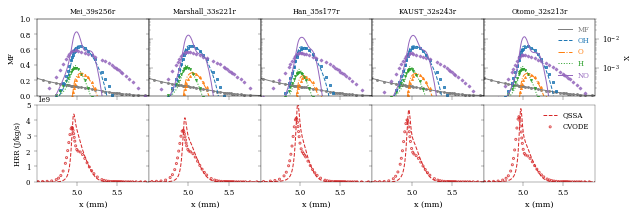

→ Saved figure!


In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─── Use generic serif font and base font size to 6 ───────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 7

# ─── User‐adjustable settings ─────────────────────────────────────────────────
data_path   = "SIM_results"
case_folder = "case_NH3_counterflow_KAUST"
mechanisms  = [
    "Mei_39s256r",
    "Marshall_33s221r",
    "Han_35s177r",
    "KAUST_32s243r",
    "Otomo_32s213r",
]
title_names = mechanisms

target_case = "N_CF_1"

# x‐range for all subplots
xlim = [4.51, 5.9]

# species for top row
cols_1 = ['MF', 'X_OH', 'X_O', 'X_H', 'X_NO']

# ─── Use Tableau “tab:” colors ────────────────────────────────────────────────
color_arr  = ['tab:gray','tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red', 'tab:purple']
symbol_arr = ['o', 's', '^', 'v', 'D']
line_arr   = ['-', '--', '-.', ':']

# ─── y‐limits ─────────────────────────────────────────────────────────────────
ylims_top = {
    'MF':   (0.0, 1.0),
    'X_OH': (1.1e-4, 5e-2),
    'X_O':  (1.1e-4, 5e-2),
    'X_H':  (1.1e-4, 5e-2),
    'X_NO': (1.1e-4, 5e-2),
}
ylims_hrr = (0, 5e9)

# ─── Prepare figure ───────────────────────────────────────────────────────────
n = len(mechanisms)
fig, axs = plt.subplots(2, n,
                        figsize=(2 * n, 3),
                        sharex=True)

if n == 1:
    axs = axs[:, np.newaxis]

for j, mech in enumerate(mechanisms):
    # ─ Top row ─────────────────────────────────────────────────────────────────
    ax_top   = axs[0, j]
    ax_top_r = ax_top.twinx()
    ax_top.set_title(title_names[j], fontsize=7)

    sim_csv = os.path.join(data_path, case_folder, mech, f"{target_case}.csv")
    if not os.path.isfile(sim_csv):
        print(f"SIM file not found: {sim_csv}")
        continue
    df_sim = pd.read_csv(sim_csv)
    grid   = df_sim['grid'] * 1000  # mm

    qssa_csv = os.path.join("figs", "QSSA",
                             data_path, case_folder,
                             target_case, mech,
                             "predicted_X.csv")
    df_qssa = pd.read_csv(qssa_csv) if os.path.isfile(qssa_csv) else pd.DataFrame()

    for i, col in enumerate(cols_1):
        mkr = symbol_arr[i % len(symbol_arr)]
        ls  = line_arr[i % len(line_arr)]
        c   = color_arr[i % len(color_arr)]
        lbl = col.replace("X_", "")

        if col == 'MF':
            ax_top.scatter(grid[::3], df_sim[col][::3],
                           s=4, alpha=0.8,
                           marker=mkr, color=c)
            if col in df_qssa:
                ax_top.plot(grid, df_qssa[col],
                            linestyle=ls, linewidth=1,
                            color=c, label=lbl)
        else:
            ax_top_r.scatter(grid[::3], df_sim[col][::3],
                             s=4, alpha=0.8,
                             marker=mkr, color=c)
            if col in df_qssa:
                ax_top_r.plot(grid, df_qssa[col],
                              linestyle=ls, linewidth=1,
                              color=c, label=lbl)

    ax_top.set_xlim(xlim)
    ax_top.set_ylim(ylims_top['MF'])
    ax_top_r.set_xlim(xlim)
    ax_top_r.set_yscale('log')
    ax_top_r.set_ylim(ylims_top[col])  # use the last radical's limits

    if j == 0:
        ax_top.set_ylabel('MF', fontsize=7)
    else:
        ax_top.tick_params(labelleft=False)

    if j == n - 1:
        ax_top_r.set_ylabel('X', fontsize=7)
        h1, l1 = ax_top.get_legend_handles_labels()
        h2, l2 = ax_top_r.get_legend_handles_labels()
        lg = ax_top_r.legend(h1 + h2, l1 + l2,
                             loc='upper right', frameon=False,
                             fontsize=7)
        for txt, ln in zip(lg.get_texts(), lg.get_lines()):
            txt.set_color(ln.get_color())
    else:
        ax_top_r.tick_params(labelright=False)

    ax_top.tick_params(labelbottom=False)

    # ─ Bottom row (HRR only) ────────────────────────────────────────────────────
    ax_bot = axs[1, j]
    ax_bot.set_xlim(xlim)
    ax_bot.set_ylim(ylims_hrr)

    # dashed line = QSSA, scatter = CVODE
    ax_bot.plot(grid, df_qssa['HRR'],
                linestyle='--', linewidth=1,
                color='tab:red', label='QSSA')
    ax_bot.scatter(grid[::2], df_sim['HRR'][::2],
                   s=4, alpha=0.8, marker='o',
                   facecolors='none', edgecolors='tab:red',
                   label='CVODE')

    if j == 0:
        ax_bot.set_ylabel('HRR (J/kg/s)', fontsize=7)
    else:
        ax_bot.tick_params(labelleft=False)

    if j == n - 1:
        ax_bot.legend(loc='upper right', frameon=False, fontsize=7)

    ax_bot.tick_params(labelbottom=True)
    ax_bot.set_xlabel('x (mm)', fontsize=8)

plt.subplots_adjust(wspace=0, hspace=0.12)
plt.show()

# ─── Save the figure ───────────────────────────────────────────────────────────
fig_dir = "figs/NH3"
os.makedirs(fig_dir, exist_ok=True)
fig.savefig(
    os.path.join(fig_dir, "Supplementary_1D_CEQ_NH3_HRR_only.pdf"),
    dpi=300, bbox_inches='tight'
)
print("→ Saved figure!") 

# Figure 5: Comparison of Adding OH 

→ Saved figure at: figs/validation/1D_CEQ_NH3_compare_with_OH.pdf


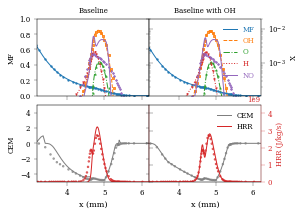

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection

# ─── Use generic serif font and set base font size to 6 ────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 6
plt.rcParams["xtick.labelsize"]  = 7   # ← increase x‐tick labels to 8pt
plt.rcParams["ytick.labelsize"]  = 7   # ← increase y‐tick labels to 8pt
# ─── User‐adjustable settings ──────────────────────────────────────────────────
data_path    = "SIM_results"
case_names   = [
    "case_NH3_counterflow_KAUST",
    "case_NH3_counterflow_KAUST_OH"
]
title_names  = [
    "Baseline",
    "Baseline with OH"
]
sim_source   = case_names[0]    # always read SIM data from this folder
target_case  = "N_CF_3"
mechanism    = "Otomo_32s213r"

# x‐range for all subplots
xlim = [3.2, 6.2]

# Dynamic lists of species/columns to plot
cols_1 = ['MF', 'X_OH', 'X_O', 'X_H', 'X_NO']
cols_3 = ['CEM', 'HRR']

# Markers, colors, linestyles (cycled through)
symbol_arr = ['o', 's', '^', 'v', 'D']
color_arr  = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink'
]
line_arr   = ['-', '--', '-.', ':', '-']

# specific tab‐colors for bottom‐row metrics
c_cem = 'tab:gray'
c_hrr = 'tab:red'

output_dir = "figs/validation"
os.makedirs(output_dir, exist_ok=True)

# ─── User‐adjustable y‐limits for each variable ────────────────────────────────
ylims_top = {
    'MF':   (0.0, 1.0),
    'X_OH': (1.1e-4, 2e-2),
    'X_O':  (1.1e-4, 2e-2),
    'X_H':  (1.1e-4, 2e-2),
    'X_NO': (1.1e-4, 2e-2),
}
ylims_middle = {
    'CEM': (-5, 5),
    'HRR': (0, 4.5e9),
}

# ─── Create subplots ──────────────────────────────────────────────────────────
n_cases = len(case_names)
fig, axs = plt.subplots(
    2, n_cases,
    figsize=(2 * n_cases, 3),
    sharex=True
)
if n_cases == 1:
    axs = axs[:, np.newaxis]

for j, case_name in enumerate(case_names):
    ax_top   = axs[0, j]
    ax_top_r = ax_top.twinx()
    ax_mid   = axs[1, j]
    ax_mid_r = ax_mid.twinx()

    ax_top.set_title(title_names[j], fontsize=7)

    # SIM data (always from sim_source)
    sim_csv = os.path.join(data_path, sim_source, mechanism, f"{target_case}.csv")
    df_sim  = pd.read_csv(sim_csv)
    grid    = df_sim['grid'] * 1000  # mm

    # QSSA data for this case
    qssa_csv = os.path.join(
        "figs", "QSSA", data_path, case_name, target_case, mechanism, "predicted_X.csv"
    )
    df_qssa = pd.read_csv(qssa_csv) if os.path.isfile(qssa_csv) else pd.DataFrame()

    # ─── Top row: MF + radicals ────────────────────────────────────────────────
    for i, col in enumerate(cols_1):
        mkr, ls, c = symbol_arr[i], line_arr[i], color_arr[i]
        lbl = col.replace("X_", "")

        if col == 'MF':
            if col in df_sim:
                ax_top.scatter(
                    grid[::3], df_sim[col][::3],
                    s=2, alpha=0.8, marker=mkr, color=c
                )
            if col in df_qssa:
                ax_top.plot(
                    grid, df_qssa[col],
                    linestyle=ls, linewidth=1, color=c, label=lbl
                )
        else:
            if col in df_sim:
                ax_top_r.scatter(
                    grid[::3], df_sim[col][::3],
                    s=2, alpha=0.8, marker=mkr, color=c
                )
            if col in df_qssa:
                ax_top_r.plot(
                    grid, df_qssa[col],
                    linestyle=ls, linewidth=1, color=c, label=lbl
                )

    # impose uniform top‐row limits
    ax_top.set_xlim(xlim)
    ax_top.set_ylim(ylims_top['MF'])
    ax_top_r.set_xlim(xlim)
    ax_top_r.set_yscale('log')
    lo, hi = ylims_top['X_OH']
    ax_top_r.set_ylim((max(lo,1e-8), hi))

    # left‐axis formatting
    if j == 0:
        ax_top.set_ylabel('MF', fontsize=7)
        ax_top.tick_params(labelleft=True)
    else:
        ax_top.tick_params(labelleft=False)

    # right‐axis formatting + legend only on last column
    if j == n_cases - 1:
        ax_top_r.set_ylabel('X', fontsize=7)
        ax_top_r.tick_params(labelright=True)
        h1, l1 = ax_top.get_legend_handles_labels()
        h2, l2 = ax_top_r.get_legend_handles_labels()
        lg = ax_top_r.legend(
            h1 + h2, l1 + l2,
            loc='upper right', frameon=False, fontsize=7
        )
        for text, line in zip(lg.get_texts(), lg.get_lines()):
            text.set_color(line.get_color())
    else:
        ax_top_r.tick_params(labelright=False)
    ax_top.tick_params(labelbottom=False)

    # ─── Bottom row: CEM + HRR ────────────────────────────────────────────────
    handles, labels = [], []
    ax_mid.set_xlabel('x (mm)', fontsize=8)
    for col in cols_3:
        if col == 'CEM':
            h_cem = ax_mid.scatter(
                grid[::3], df_sim['CEM'][::3],
                s=2, alpha=0.8,
                marker='o', facecolors='none', edgecolors=c_cem
            )
            if 'CEM' in df_qssa:
                line_cem, = ax_mid.plot(
                        grid, df_qssa['CEM'],
                        linestyle='-', linewidth=1, color=c_cem
                    )
                handles.append(line_cem)
                labels.append('CEM')
        else:  # HRR
            if 'HRR' in df_qssa:
                h_hrr = ax_mid_r.plot(
                    grid, df_qssa['HRR'],
                    linestyle='-', linewidth=1, color=c_hrr
                )[0]
                handles.append(h_hrr)
                labels.append('HRR')
            ax_mid_r.scatter(
                grid[::2], df_sim['HRR'][::2],
                s=2, alpha=0.8,
                marker='o', facecolors='none', edgecolors=c_hrr
            )

    # impose uniform bottom‐row limits
    ax_mid .set_xlim(xlim)
    ax_mid .set_ylim(ylims_middle['CEM'])
    ax_mid_r.set_xlim(xlim)
    ax_mid_r.set_ylim(ylims_middle['HRR'])

    # color right spine always, but only enable ticklabels & label in last column
    ax_mid_r.spines['right'].set_color(c_hrr)
    ax_mid_r.yaxis.label.set_color(c_hrr)
    if j == n_cases - 1:
        ax_mid_r.tick_params(
            axis='y',
            labelright=True,
            labelcolor=c_hrr,
            colors=c_hrr
        )
    else:
        ax_mid_r.tick_params(axis='y', labelright=False)

    # bottom row left‐axis formatting
    if j == 0:
        ax_mid.set_ylabel('CEM', fontsize=7)
        ax_mid.tick_params(labelleft=True)
    else:
        ax_mid.tick_params(labelleft=False)

    # legend in last column, robust text‐coloring
    if j == n_cases - 1:
        ax_mid_r.set_ylabel('HRR (J/kg/s)', fontsize=7, color=c_hrr)
        lg2 = ax_mid.legend(
            handles, labels,
            loc='upper right', frameon=False, fontsize=7
        )
    for txt, handle in zip(lg2.get_texts(), lg2.legend_handles):
        if isinstance(handle, Line2D):
            col = handle.get_color()
        elif isinstance(handle, PathCollection):
            ec = handle.get_edgecolor()
            # edgecolor is Nx4 array if multiple, or 4‐vector if single
            col = ec[0] if ec.ndim > 1 else ec
        else:
            col = 'k'
            txt.set_color(c)

    ax_mid.tick_params(labelbottom=True)

plt.subplots_adjust(wspace=0, hspace=0.12)

# ─── Save the figure ───────────────────────────────────────────────────────────
out_file = os.path.join(output_dir, "1D_CEQ_NH3_compare_with_OH.pdf")
fig.savefig(out_file, dpi=300, bbox_inches='tight')
print(f"→ Saved figure at: {out_file}")

# Figure 4: Reconstruction over space

## -- The largest non-zero eigenvalue of the Jacobian matrix J is denoted asΛe. The real part ofΛe,Re(Λe), indicates the stability of states, -->

→ Saved figure at: figs/NH3/Supplementary_1D_CEQ_NH3_combine_expanded_OH.pdf


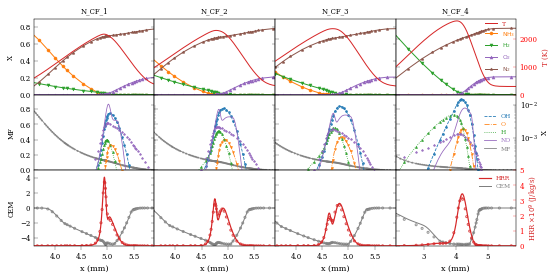

In [52]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection

# ─── User‐adjustable settings ──────────────────────────────────────────────────

# 1) Root of all SIMULATION folders:
method_path = "SIM_results"

# 2) The “case_name” subfolder to look under:
case_name = "case_NH3_counterflow_KAUST_OH"

# 3) Fixed mechanism folder name:
mech = "Otomo_32s213r"

# 4) The list of target cases to use:
target_case_assemble = [
    # 'N_CF_0',
    'N_CF_1',
    'N_CF_2',
    'N_CF_3',
    'N_CF_4',
    
    # (feel free to re‐enable others if needed)
]

# 5) Display names for each panel (can be identical to target_case names):
target_name_assemble = [
    # 'N_CF_0',
    'N_CF_1',
    'N_CF_2',
    'N_CF_3',
    'N_CF_4',
    
]

# 6) x‐ranges for each target case:
x_range_assemble = [
    [3.6, 5.9],
    [3.6, 5.9],
    [3.6, 5.9],
    [2.1, 5.9],
]

species_labels = {
    "NH3": r"$\mathrm{NH}_3$",
    "H2":  r"$\mathrm{H}_2$",
    "H2O": r"$\mathrm{H}_2\mathrm{O}$",
    "N2":  r"$\mathrm{N}_2$",
    "O2":  r"$\mathrm{O}_2$",
}


# 7) Line styles, colors, markers (cycled through):
line_arr   = ('-','--','-.',':')
color_arr  = [
    'tab:red',
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:purple',
    'tab:brown',
    'tab:pink'
]
symbol_arr = ('s','o','v','^','*')


# ###################### Plot FIGURE RECONSTRUCT SPACE ######################
fig, axs = plt.subplots(
    3,
    len(target_case_assemble),
    figsize=(1.8 * len(target_case_assemble), 3.5),
    sharex=False,
)

# Ensure axs is always 2D even if there's only one column
if len(target_case_assemble) == 1:
    axs = axs[:, np.newaxis]

# Columns to plot in each row
cols_1 = ['T',    'X_NH3', 'X_H2', 'X_O2', 'X_N2']
cols_2 = ['MF',   'X_OH',  'X_O',  'X_H',  'X_NO']
cols_3 = ['HRR',  'CEM']

# ─── User‐adjustable y‐limits for each variable ────────────────────────────────
cols_2_range = {
    'MF':   (0.0, 0.99),       # MF is always linear [0,1]
    'X_OH': (1.1e-4, 2e-2),
    'X_O':  (1.1e-4, 2e-2),
    'X_H':  (1.1e-4, 2e-2),
    'X_NO': (1.1e-4, 2e-2),
}

cols_3_range = {
    'CEM': (-5, 5),
    'HRR': (0, 5e9),
}


for j, target_case in enumerate(target_case_assemble):
    # ─── Read SIM (original) data for this mechanism ───────────────────────────
    sim_csv_path = os.path.join(method_path, case_name, mech, f"{target_case}.csv")
    if not os.path.isfile(sim_csv_path):
        print(f"  → File not found: {sim_csv_path}")
        continue

    df_sim = pd.read_csv(sim_csv_path)
    grid = df_sim['grid'].to_numpy() * 1000  # convert to mm

    # ─── Read reconstructed (QSSA) data for this mechanism ────────────────────
    qssa_path = os.path.join("figs", "QSSA", method_path, case_name, target_case, mech, "predicted_X.csv")
    if os.path.isfile(qssa_path):
        df_qssa = pd.read_csv(qssa_path)
    else:
        df_qssa = pd.DataFrame()

    # ─── Row 1: Plot cols_1 ──────────────────────────────────────────────────
    ax1 = axs[0, j]
    ax2 = ax1.twinx()

    for i, col in enumerate(cols_1):
        ls = line_arr[i % len(line_arr)]
        c = 'tab:red' if col == 'T' else color_arr[(i+1) % len(color_arr)]

        if col == 'T':
            # Plot temperature on the right axis
            if 'T' in df_sim.columns:
                ax2.plot(grid,
                         df_sim['T'].to_numpy(),
                         linestyle='-', linewidth=1, 
                         color='tab:red',
                         label='T')
        else:
            # Plot QSSA (reconstructed) on left, SIM scatter for comparison
            pretty = col.replace("X_", "")
            if col in df_qssa.columns:
                ax1.plot(
                    grid[::5],
                    df_qssa[col].to_numpy()[::5],
                    linestyle='-',
                    linewidth=1,
                    marker=symbol_arr[i % len(symbol_arr)],
                    markersize=3,               # <-- smaller markers
                    markeredgewidth=0.5,        # <-- optional, to make the marker outline thinner
                    color=c,
                    label=species_labels[pretty]
                )
            # if col in df_sim.columns:
            #     ax1.scatter(grid[::3],
            #                 df_sim[col].to_numpy()[::3],
            #                 s=4, alpha=0.8,
            #                 marker='o',
            #                 color=c)

    # Set x and y limits for row 1
    ax1.set_xlim(x_range_assemble[j])
    ax2.set_xlim(x_range_assemble[j])
    ax1.set_ylim(0, 0.89)     # still hard‐coded for X‐species in row1
    ax2.set_ylim(0, 2700)

    # Y‐labeling and ticks for row 1
    if j == 0:
        ax1.set_ylabel('X', fontsize=7, color='black')
        ax1.tick_params(axis='y', labelleft=True, labelright=False, direction='in')
        ax2.tick_params(axis='y', labelleft=False, labelright=False)
    elif j == len(target_case_assemble) - 1:
        ax2.set_ylabel('T (K)', fontsize=7, color='tab:red')
        # Combined legend inside the last panel
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles1, labels1 = ax1.get_legend_handles_labels()
        combined_handles = handles2 + handles1
        combined_labels = labels2 + labels1
        legend = ax1.legend(combined_handles,
                            combined_labels,
                            # loc='center right',
                            bbox_to_anchor=(0.7, 0.2),
                            frameon=False,
                            fontsize=6)
        for text, line in zip(legend.get_texts(), legend.get_lines()):
            text.set_color(line.get_color())
        ax2.tick_params(axis='y', labelleft=False, colors='red', direction='in', labelright=True)
        ax1.tick_params(axis='y', labelleft=False, labelright=False)
    else:
        ax2.tick_params(axis='y', labelleft=False, labelright=False)
        ax1.tick_params(axis='y', labelleft=False, labelright=False)

    ax1.tick_params(axis='x', labelbottom=False)
    ax1.set_title(f"{target_name_assemble[j]}", fontsize=7)

    # ─── Row 2: Plot cols_2 ──────────────────────────────────────────────────
    ax1_2 = axs[1, j]
    ax2_2 = ax1_2.twinx()

    for i, col in enumerate(cols_2):
        ls = line_arr[i % len(line_arr)]
        pretty = col.replace("X_", "")
        # MF on left axis (tab:gray), all others on right axis (colored)
        if col == 'MF':
            if 'MF' in df_qssa.columns:
                ax1_2.plot(grid,
                           df_qssa['MF'].to_numpy(),
                           linestyle=ls, linewidth=0.8,
                           color='tab:gray',
                           label='MF')
            if 'MF' in df_sim.columns:
                ax1_2.scatter(grid,
                              df_sim['MF'].to_numpy(),
                              s=1, alpha=0.8,
                              marker='o',
                              facecolors='none', edgecolors='tab:gray')
        else:
            c = color_arr[i % len(color_arr)]
            if col in df_sim.columns:
                ax2_2.scatter(grid[::3],
                              df_sim[col].to_numpy()[::3],
                              s=3, alpha=0.8,
                              marker=symbol_arr[i % len(symbol_arr)],
                              color=c)
            if col in df_qssa.columns:
                ax2_2.plot(grid,
                           df_qssa[col].to_numpy(),
                           linestyle=ls, linewidth=0.8,
                           color=c,
                           label=pretty)

    # Set axis limits and log scale for row 2 using the dictionaries:
    ax1_2.set_xlim(x_range_assemble[j])
    ax2_2.set_xlim(x_range_assemble[j])

    # Left y‐limit for MF:
    y_min, y_max = cols_2_range['MF']
    ax1_2.set_ylim(y_min, y_max)

    # Right y‐limit for all other X‐species:
    # We know all non‐MF species share the same range in cols_2_range
    # (X_OH, X_O, X_H, X_NO). So just pick one of them:
    y_min2, y_max2 = cols_2_range['X_OH']
    ax2_2.set_ylim(y_min2, y_max2)
    ax2_2.set_yscale('log')

    # Y‐labeling and ticks for row 2
    if j == 0:
        ax1_2.set_ylabel('MF', fontsize=7, color='black')
        ax1_2.tick_params(axis='y', labelleft=True, colors='black', direction='in', labelright=False)
        ax2_2.tick_params(axis='y', labelleft=False, labelright=False, direction='in')
    elif j == len(target_case_assemble) - 1:
        ax2_2.set_ylabel('X', fontsize=7)
        # Combined legend inside the last panel for row 2
        h_ax2_2, l_ax2_2 = ax2_2.get_legend_handles_labels()
        h_ax1_2, l_ax1_2 = ax1_2.get_legend_handles_labels()
        combined_h2 = h_ax2_2 + h_ax1_2
        combined_l2 = l_ax2_2 + l_ax1_2
        legend_2 = ax1_2.legend(
            combined_h2,
            combined_l2,
            loc='center right',
            # bbox_to_anchor=(0.55, 0.55),
            frameon=False,
            fontsize=6
        )
        for text, line in zip(legend_2.get_texts(), legend_2.get_lines()):
            text.set_color(line.get_color())
            
        ax2_2.tick_params(which='both',axis='y', labelleft=False, direction='in', labelright=True)
        ax1_2.tick_params(axis='y', labelleft=False, direction='in', labelright=False)
    else:
        ax1_2.tick_params(axis='y', labelleft=False, direction='in', labelright=False)
        ax2_2.tick_params(which='both',axis='y', labelleft=False, direction='in', labelright=False)

    ax1_2.tick_params(axis='x', labelbottom=False)

    # ─── Row 3: Plot cols_3 ──────────────────────────────────────────────────
    ax1_3 = axs[2, j]
    ax2_3 = ax1_3.twinx()

    legend_handles = []
    legend_labels = []

    for i, col in enumerate(cols_3):
        ls = line_arr[i % len(line_arr)]
        m = symbol_arr[j % len(symbol_arr)]
        # We want CEM in tab:gray on the left, HRR in red on the right
        if col == 'CEM':
            # Reconstructed CEM (line) and SIM scatter, both on left axis
            if 'CEM' in df_qssa.columns:
                h_line, = ax1_3.plot(grid,
                           df_qssa['CEM'].to_numpy(),
                           linestyle='-', linewidth=1,
                           color='tab:gray',
                           label='CEM')
                legend_handles.append(h_line)
                legend_labels.append('CEM')
            if 'CEM' in df_sim.columns:
                h_cem = ax1_3.scatter(grid[::3],
                                      df_sim['CEM'].to_numpy()[::3],
                                      s=4, alpha=0.8,
                                      marker='o',
                                      facecolors='none', edgecolors='tab:gray',
                                      color='tab:gray')


            # Apply the CEM y‐limit from cols_3_range:
            y1_min, y1_max = cols_3_range['CEM']
            ax1_3.set_ylim(y1_min, y1_max)

        elif col == 'HRR':
            # Reconstructed HRR (scatter) and SIM HRR (line), both on right axis,
            # with SIM divided by 1e9
            if 'HRR' in df_qssa.columns:
                ax2_3.scatter(grid[::3],
                              df_sim['HRR'].to_numpy()[::3] / 1e9,
                              s=4, alpha=0.8,
                              facecolors='none', edgecolors='tab:red', label='HRR',)
            if 'HRR' in df_sim.columns:
                h_hrr = ax2_3.plot(grid,
                                   df_qssa['HRR'].to_numpy() / 1e9,
                                   linestyle=ls, linewidth=1.2,
                                   color='tab:red',
                                   label='HRR')[0]
                legend_handles.append(h_hrr)
                legend_labels.append('HRR')

            # HRR range was (0, 4e9); after dividing by 1e9 it becomes (0, 4.0)
            y2_min, y2_max = cols_3_range['HRR']
            ax2_3.set_ylim(y2_min / 1e9, y2_max / 1e9)

    # Set axis limits for row 3
    ax1_3.set_xlim(x_range_assemble[j])
    ax2_3.set_xlim(x_range_assemble[j])

    # Y‐labeling and ticks for row 3
    if j == 0:
        ax1_3.set_ylabel('CEM', fontsize=7, color='black')
        ax1_3.tick_params(axis='y', labelleft=True, colors='black', direction='in', labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, labelright=False, direction='in')
    elif j == len(target_case_assemble) - 1:
        ax2_3.set_ylabel(r'HRR $\times 10^{9}$ (J/kg/s)', fontsize=7, color='tab:red')
        # Combined legend inside the last panel for row 3
        legend_3 = ax2_3.legend(handles=legend_handles,
                                 labels=legend_labels,
                                 loc='upper right',
                                #  bbox_to_anchor=(0.55, 0.55),
                                 frameon=False,
                                 fontsize=6)
        for text, line in zip(legend_3.get_texts(), legend_3.get_lines()):
            # color text to match its handle
            if isinstance(line, Line2D):
                col_text = line.get_color()
            elif isinstance(line, PathCollection):
                col_text = line.get_facecolor()[0]
            else:
                col_text = line.get_edgecolor()[0]
            text.set_color(col_text)
        ax1_3.tick_params(axis='y', labelleft=False, labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, colors='r', direction='in', labelright=True)
    else:
        ax1_3.tick_params(axis='y', labelleft=False, labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, labelright=False)

    # X‐axis label on bottom row
    ax1_3.set_xlabel('x (mm)', fontsize=8)
    ax1_3.tick_params(axis='x', labelbottom=True)
    
plt.subplots_adjust(
    left=0.05,    # space on left
    right=0.98,   # space on right
    bottom=0.05,  # space on bottom
    top=0.95,     # space on top
    wspace=0,  # width space between columns
    hspace=0   # height space between rows
)

# plt.tight_layout()
# ─── Save the figure ───────────────────────────────────────────────────────────
fig_dir = "figs/NH3"
os.makedirs(fig_dir, exist_ok=True)
out_file = os.path.join(fig_dir, "Supplementary_1D_CEQ_NH3_combine_expanded_OH.pdf")
# out_file = os.path.join(fig_dir, "1D_CEQ_NH3_combine_expanded.pdf")

plt.savefig(out_file, dpi=300, bbox_inches='tight') 
print(f"→ Saved figure at: {out_file}")

# Figure S.2: Reconstruction over space （dilution ratio）


→ Saved figure at: figs/NH3/Supplementary_1D_CEQ_NH3_combine_expanded_dilution.pdf


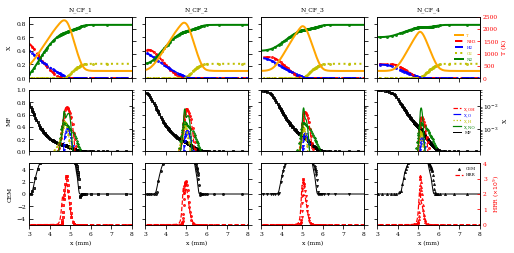

In [128]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection

# ─── User‐adjustable settings ──────────────────────────────────────────────────

# 1) Root of all SIMULATION folders:
method_path = "SIM_results"

# 2) The “case_name” subfolder to look under:
case_name = "case_NH3_counterflow_PCI_matrix"

# 3) Fixed mechanism folder name:
mech = "Otomo_32s213r"

# 4) The list of target cases to use:
target_case_assemble = [
    'N_CF_NH3_0.50_H2_0.50_N2_0.00',
    'N_CF_NH3_0.40_H2_0.40_N2_0.20',
    'N_CF_NH3_0.30_H2_0.30_N2_0.40',
    'N_CF_NH3_0.20_H2_0.20_N2_0.60',
]

# 5) Display names for each panel (can be identical to target_case names):
target_name_assemble = [
    # 'N_CF_0',
    'N_CF_1',
    'N_CF_2',
    'N_CF_3',
    'N_CF_4',
    
]

# 6) x‐ranges for each target case:
x_range_assemble = [
    [3, 8],
    [3, 8],
    [3, 8],
    [3, 8],
    [3, 8],
]

# 7) Line styles, colors, markers (cycled through):
line_arr = ('-','--','-.',':')
color_arr = ('k','r','b','y','g','c','m')
symbol_arr = ('s','o','v','^','*')

# ###################### Plot FIGURE RECONSTRUCT SPACE ######################
fig, axs = plt.subplots(
    3,
    len(target_case_assemble),
    figsize=(1.8 * len(target_case_assemble), 3.5),
    sharex=True
)

# Ensure axs is always 2D even if there's only one column
if len(target_case_assemble) == 1:
    axs = axs[:, np.newaxis]

# Columns to plot in each row
cols_1 = ['T',    'X_NH3', 'X_H2', 'X_O2', 'X_N2']
cols_2 = ['MF',   'X_OH',  'X_O',  'X_H',  'X_NO']
cols_3 = ['CEM',  'HRR']

# ─── User‐adjustable y‐limits for each variable ────────────────────────────────
cols_2_range = {
    'MF':   (0.0, 1.0),       # MF is always linear [0,1]
    'X_OH': (1.1e-4, 5e-2),
    'X_O':  (1.1e-4, 5e-2),
    'X_H':  (1.1e-4, 5e-2),
    'X_NO': (1.1e-4, 5e-2),
}

cols_3_range = {
    'CEM': (-5, 5),
    'HRR': (0, 4e9),
}


for j, target_case in enumerate(target_case_assemble):
    # ─── Read SIM (original) data for this mechanism ───────────────────────────
    sim_csv_path = os.path.join(method_path, case_name, mech, f"{target_case}.csv")
    if not os.path.isfile(sim_csv_path):
        print(f"  → File not found: {sim_csv_path}")
        continue

    df_sim = pd.read_csv(sim_csv_path)
    grid = df_sim['grid'].to_numpy() * 1000  # convert to mm

    # ─── Read reconstructed (QSSA) data for this mechanism ────────────────────
    qssa_path = os.path.join("figs", "QSSA", method_path, case_name, target_case, mech, "predicted_X.csv")
    if os.path.isfile(qssa_path):
        df_qssa = pd.read_csv(qssa_path)
    else:
        df_qssa = pd.DataFrame()

    # ─── Row 1: Plot cols_1 ──────────────────────────────────────────────────
    ax1 = axs[0, j]
    ax2 = ax1.twinx()

    for i, col in enumerate(cols_1):
        ls = line_arr[i % len(line_arr)]
        c = 'orange' if col == 'T' else color_arr[i % len(color_arr)]
        pretty = col.replace("X_", "")
        if col == 'T':
            # Plot temperature on the right axis
            if 'T' in df_sim.columns:
                ax2.plot(grid,
                         df_sim['T'].to_numpy(),
                         linestyle=ls, linewidth=2,
                         color='orange',
                         label='T')
        else:
            # Plot QSSA (reconstructed) on left, SIM scatter for comparison
            if col in df_qssa.columns:
                ax1.plot(grid,
                         df_qssa[col].to_numpy(),
                         linestyle=ls, linewidth=2,
                         color=c,
                         label=pretty)
            if col in df_sim.columns:
                ax1.scatter(grid[::3],
                            df_sim[col].to_numpy()[::3],
                            s=4, alpha=0.8,
                            marker='o',
                            color=c)

    # Set x and y limits for row 1
    ax1.set_xlim(x_range_assemble[j])
    ax2.set_xlim(x_range_assemble[j])
    ax1.set_ylim(0, 0.9)     # still hard‐coded for X‐species in row1
    ax2.set_ylim(0, 2500)

    # Y‐labeling and ticks for row 1
    if j == 0:
        ax1.set_ylabel('X', fontsize=6, color='black')
        ax1.tick_params(axis='y', labelleft=True, labelright=False, direction='in')
        ax2.tick_params(axis='y', labelleft=False, labelright=False)
    elif j == len(target_case_assemble) - 1:
        ax2.set_ylabel('T (K)', fontsize=6, color='red')
        # Combined legend inside the last panel
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles1, labels1 = ax1.get_legend_handles_labels()
        combined_handles = handles2 + handles1
        combined_labels = labels2 + labels1
        legend = ax1.legend(combined_handles,
                            combined_labels,
                            loc='center right',
                            # bbox_to_anchor=(0.55, 0.55),
                            frameon=False,
                            fontsize=4)
        for text, line in zip(legend.get_texts(), legend.get_lines()):
            text.set_color(line.get_color())
        ax2.tick_params(axis='y', labelleft=False, colors='red', direction='in', labelright=True)
        ax1.tick_params(axis='y', labelleft=False, labelright=False)
    else:
        ax2.tick_params(axis='y', labelleft=False, labelright=False)
        ax1.tick_params(axis='y', labelleft=False, labelright=False)

    ax1.tick_params(axis='x', labelbottom=False)
    ax1.set_title(f"{target_name_assemble[j]}", fontsize=6)

    # ─── Row 2: Plot cols_2 ──────────────────────────────────────────────────
    ax1_2 = axs[1, j]
    ax2_2 = ax1_2.twinx()

    for i, col in enumerate(cols_2):
        ls = line_arr[i % len(line_arr)]
        # MF on left axis (black), all others on right axis (colored)
        if col == 'MF':
            if 'MF' in df_qssa.columns:
                ax1_2.plot(grid,
                           df_qssa['MF'].to_numpy(),
                           linestyle=ls, linewidth=1,
                           color='black',
                           label='MF')
            if 'MF' in df_sim.columns:
                ax1_2.scatter(grid,
                              df_sim['MF'].to_numpy(),
                              s=4, alpha=0.8,
                              marker=symbol_arr[i % len(symbol_arr)],
                              color='black')
        else:
            c = color_arr[i % len(color_arr)]
            if col in df_sim.columns:
                ax2_2.scatter(grid[::3],
                              df_sim[col].to_numpy()[::3],
                              s=4, alpha=0.8,
                              marker=symbol_arr[i % len(symbol_arr)],
                              color=c)
            if col in df_qssa.columns:
                ax2_2.plot(grid,
                           df_qssa[col].to_numpy(),
                           linestyle=ls, linewidth=1.2,
                           color=c,
                           label=col)

    # Set axis limits and log scale for row 2 using the dictionaries:
    ax1_2.set_xlim(x_range_assemble[j])
    ax2_2.set_xlim(x_range_assemble[j])

    # Left y‐limit for MF:
    y_min, y_max = cols_2_range['MF']
    ax1_2.set_ylim(y_min, y_max)

    # Right y‐limit for all other X‐species:
    # We know all non‐MF species share the same range in cols_2_range
    # (X_OH, X_O, X_H, X_NO). So just pick one of them:
    y_min2, y_max2 = cols_2_range['X_OH']
    ax2_2.set_ylim(y_min2, y_max2)
    ax2_2.set_yscale('log')

    # Y‐labeling and ticks for row 2
    if j == 0:
        ax1_2.set_ylabel('MF', fontsize=6, color='black')
        ax1_2.tick_params(axis='y', labelleft=True, colors='black', direction='in', labelright=False)
        ax2_2.tick_params(axis='y', labelleft=False, labelright=False, direction='in')
    elif j == len(target_case_assemble) - 1:
        ax2_2.set_ylabel('X', fontsize=6)
        # Combined legend inside the last panel for row 2
        h_ax2_2, l_ax2_2 = ax2_2.get_legend_handles_labels()
        h_ax1_2, l_ax1_2 = ax1_2.get_legend_handles_labels()
        combined_h2 = h_ax2_2 + h_ax1_2
        combined_l2 = l_ax2_2 + l_ax1_2
        legend_2 = ax1_2.legend(
            combined_h2,
            combined_l2,
            loc='center right',
            # bbox_to_anchor=(0.55, 0.55),
            frameon=False,
            fontsize=4
        )
        for text, line in zip(legend_2.get_texts(), legend_2.get_lines()):
            text.set_color(line.get_color())
        ax2_2.tick_params(axis='y', labelleft=False, direction='in', labelright=True)
        ax1_2.tick_params(axis='y', labelleft=False, labelright=False)
    else:
        ax1_2.tick_params(axis='y', labelleft=False, labelright=False)
        ax2_2.tick_params(axis='y', labelleft=False, labelright=False)

    ax1_2.tick_params(axis='x', labelbottom=False)

    # ─── Row 3: Plot cols_3 ──────────────────────────────────────────────────
    ax1_3 = axs[2, j]
    ax2_3 = ax1_3.twinx()

    legend_handles = []
    legend_labels = []

    for i, col in enumerate(cols_3):
        ls = line_arr[i % len(line_arr)]
        m = symbol_arr[j % len(symbol_arr)]
        # We want CEM in black on the left, HRR in red on the right
        if col == 'CEM':
            # Reconstructed CEM (line) and SIM scatter, both on left axis
            if 'CEM' in df_qssa.columns:
                ax1_3.plot(grid,
                           df_qssa['CEM'].to_numpy(),
                           linestyle=ls, linewidth=1,
                           color='k',
                           label='CEM')
            if 'CEM' in df_sim.columns:
                h_cem = ax1_3.scatter(grid[::2],
                                      df_sim['CEM'].to_numpy()[::2],
                                      s=4, alpha=0.8,
                                      marker=m,
                                      color='k')
                legend_handles.append(h_cem)
                legend_labels.append('CEM')

            # Apply the CEM y‐limit from cols_3_range:
            y1_min, y1_max = cols_3_range['CEM']
            ax1_3.set_ylim(y1_min, y1_max)

        elif col == 'HRR':
            # Reconstructed HRR (scatter) and SIM HRR (line), both on right axis,
            # with SIM divided by 1e9
            if 'HRR' in df_qssa.columns:
                ax2_3.scatter(grid[::2],
                              df_qssa['HRR'].to_numpy()[::2] / 1e9,
                              s=4, alpha=0.8,
                              marker=m,
                              color='r')
            if 'HRR' in df_sim.columns:
                h_hrr = ax2_3.plot(grid,
                                   df_sim['HRR'].to_numpy() / 1e9,
                                   linestyle=ls, linewidth=1.2,
                                   color='r',
                                   label='HRR')[0]
                legend_handles.append(h_hrr)
                legend_labels.append('HRR')

            # HRR range was (0, 4e9); after dividing by 1e9 it becomes (0, 4.0)
            y2_min, y2_max = cols_3_range['HRR']
            ax2_3.set_ylim(y2_min / 1e9, y2_max / 1e9)

    # Set axis limits for row 3
    ax1_3.set_xlim(x_range_assemble[j])
    ax2_3.set_xlim(x_range_assemble[j])

    # Y‐labeling and ticks for row 3
    if j == 0:
        ax1_3.set_ylabel('CEM', fontsize=6, color='black')
        ax1_3.tick_params(axis='y', labelleft=True, colors='black', direction='in', labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, labelright=False, direction='in')
    elif j == len(target_case_assemble) - 1:
        ax2_3.set_ylabel(r'HRR ($\times 10^{9}$)', fontsize=6, color='r')
        # Combined legend inside the last panel for row 3
        legend_3 = ax2_3.legend(handles=legend_handles,
                                 labels=legend_labels,
                                 loc='upper right',
                                #  bbox_to_anchor=(0.55, 0.55),
                                 frameon=False,
                                 fontsize=4)
        # for text, line in zip(legend_3.get_texts(), legend_3.get_lines()):
        #     # color text to match its handle
        #     if isinstance(line, Line2D):
        #         col_text = line.get_color()
        #     elif isinstance(line, PathCollection):
        #         col_text = line.get_facecolor()[0]
        #     else:
        #         col_text = line.get_edgecolor()[0]
        #     text.set_color(col_text)
        ax1_3.tick_params(axis='y', labelleft=False, labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, colors='r', direction='in', labelright=True)
    else:
        ax1_3.tick_params(axis='y', labelleft=False, labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, labelright=False)

    # X‐axis label on bottom row
    ax1_3.set_xlabel('x (mm)', fontsize=6)
    ax1_3.tick_params(axis='x', labelbottom=True)

plt.tight_layout()
# ─── Save the figure ───────────────────────────────────────────────────────────
fig_dir = "figs/NH3"
os.makedirs(fig_dir, exist_ok=True)
out_file = os.path.join(fig_dir, "Supplementary_1D_CEQ_NH3_combine_expanded_dilution.pdf")
plt.savefig(out_file, dpi=300, bbox_inches='tight')
print(f"→ Saved figure at: {out_file}")

# Figure 6: Compare Normalized HRR reconstruction of different cases using Otomo

<ipython-input-14-f7d5b9ea187a>:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.90])


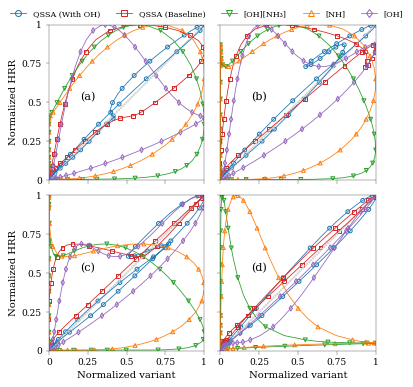

→ Saved figure at: figs/validation/HRR_vs_variants_2x2_with_quarter_ticks.pdf


In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ─── User‐adjustable settings ──────────────────────────────────────────────────
data_path             = "SIM_results"
row1_qssa_case_name   = "case_NH3_counterflow_KAUST"
row2_qssa_case_name   = "case_NH3_counterflow_KAUST_OH"
target_cases          = ["N_CF_1", "N_CF_2", "N_CF_3", "N_CF_4"]
label_names           = ["(a)", "(b)", "(c)", "(d)"]
mech                  = "Otomo_32s213r"

# ─── Plot‐style arrays ─────────────────────────────────────────────────────────
# Each entry: (legend_label, linestyle, color, marker)
series_info = [
    # y = x reference: no label, light gray
    (None,           "dotted",   "lightgray", None),
    # (None,           "dotted",   "white", None),
    ("QSSA (With OH)",  "-",      "tab:blue",   "o"),
    ("QSSA (Baseline)", "-",      "tab:red",    "s"),
    ("[OH][NH₃]",       "-",      "tab:green",  "v"),
    ("[NH]",            "-",      "tab:orange","^"),
    ("[OH]",            "-",      "tab:purple","d"),
]

n_rows, n_cols = 2, 2
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(3 * n_cols, 3 * n_rows),
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0.1, 'wspace': 0.05}
)
axes = axes.flatten()

def plot_one_subplot(ax, target_case):
    sim_csv = os.path.join(data_path, row1_qssa_case_name, mech, f"{target_case}.csv")
    df_sim  = pd.read_csv(sim_csv)

    qssa1 = os.path.join("figs","QSSA",data_path,row1_qssa_case_name,
                         target_case, mech, "predicted_X.csv")
    df_qssa1 = pd.read_csv(qssa1)

    qssa2 = os.path.join("figs","QSSA",data_path,row2_qssa_case_name,
                         target_case, mech, "predicted_X.csv")
    df_qssa2 = pd.read_csv(qssa2)

    sim_hrr = df_sim["HRR"].to_numpy()
    sim_norm = sim_hrr / sim_hrr.max()

    variants = [
        (sim_norm, sim_norm),
        (df_qssa2["HRR"].to_numpy()/df_qssa2["HRR"].max(), sim_norm),
        (df_qssa1["HRR"].to_numpy()/df_qssa1["HRR"].max(), sim_norm),
        ((df_sim["X_OH"]*df_sim["X_NH3"])/ (df_sim["X_OH"]*df_sim["X_NH3"]).max(), sim_norm),
        (df_sim["X_NH"]/df_sim["X_NH"].max(), sim_norm),
        (df_sim["X_OH"]/df_sim["X_OH"].max(), sim_norm),
    ]

    for (label, ls, color, marker), (x_arr, y_arr) in zip(series_info, variants):
        if marker is None:
            ax.plot(x_arr, y_arr, linestyle=ls, color=color, linewidth=2.0)
        else:
            ax.plot(x_arr, y_arr, linestyle=ls, color=color, linewidth=0.8)
            ax.scatter(
                x_arr[::2], y_arr[::2],
                s=15, marker=marker,
                facecolors='none',
                edgecolors=color,
                label=label
            )

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_aspect('equal', adjustable='box')
    ticks = [0, 0.25, 0.5, 0.75, 1]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    # ← new: force tick labels to exactly [0,0.25,0.5,0.75,1]
    labels = [f"{t:g}" for t in ticks]
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    idx = target_cases.index(target_case)
    col = idx % n_cols
    row = idx // n_cols
    if col==0:
        ax.set_ylabel("Normalized HRR", fontsize=10)
        ax.tick_params(axis='y', labelsize=9)
    else:
        ax.tick_params(axis='y', labelleft=False)
    if row==n_rows-1:
        ax.set_xlabel("Normalized variant", fontsize=10)
        ax.tick_params(axis='x', labelsize=9)
    else:
        ax.tick_params(axis='x', labelbottom=False)

    ax.text(0.3,0.5,label_names[idx],
            transform=ax.transAxes, ha='right', va='bottom', fontsize=11)

for case, ax in zip(target_cases, axes):
    plot_one_subplot(ax, case)

# external legend
proxy_handles, proxy_labels = [], []
for label, ls, color, marker in series_info:
    if label is None:
        continue      # ← skip y=x
    if marker is None:
        ph = Line2D([0],[0], linestyle=ls, color=color, linewidth=2.0)
    else:
        ph = Line2D(
            [0],[0],
            linestyle=ls, color=color,
            marker=marker, markerfacecolor='none',
            markeredgecolor=color, markersize=6, linewidth=0.8
        )
    proxy_handles.append(ph)
    proxy_labels.append(label)

fig.legend(
    proxy_handles, proxy_labels,
    loc='upper center', ncol=len(proxy_handles),
    frameon=False, fontsize=8, bbox_to_anchor=(0.5,0.93)
)

fig.tight_layout(rect=[0,0,1,0.90])
out_dir = "figs/validation"
os.makedirs(out_dir, exist_ok=True)
save_path = os.path.join(out_dir, "HRR_vs_variants_2x2_with_quarter_ticks.pdf")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"→ Saved figure at: {save_path}")

# Supplementary figure S.3: Compare Normalized HRR reconstruction of different cases using Han

<ipython-input-200-cdd82b510ca9>:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,1])


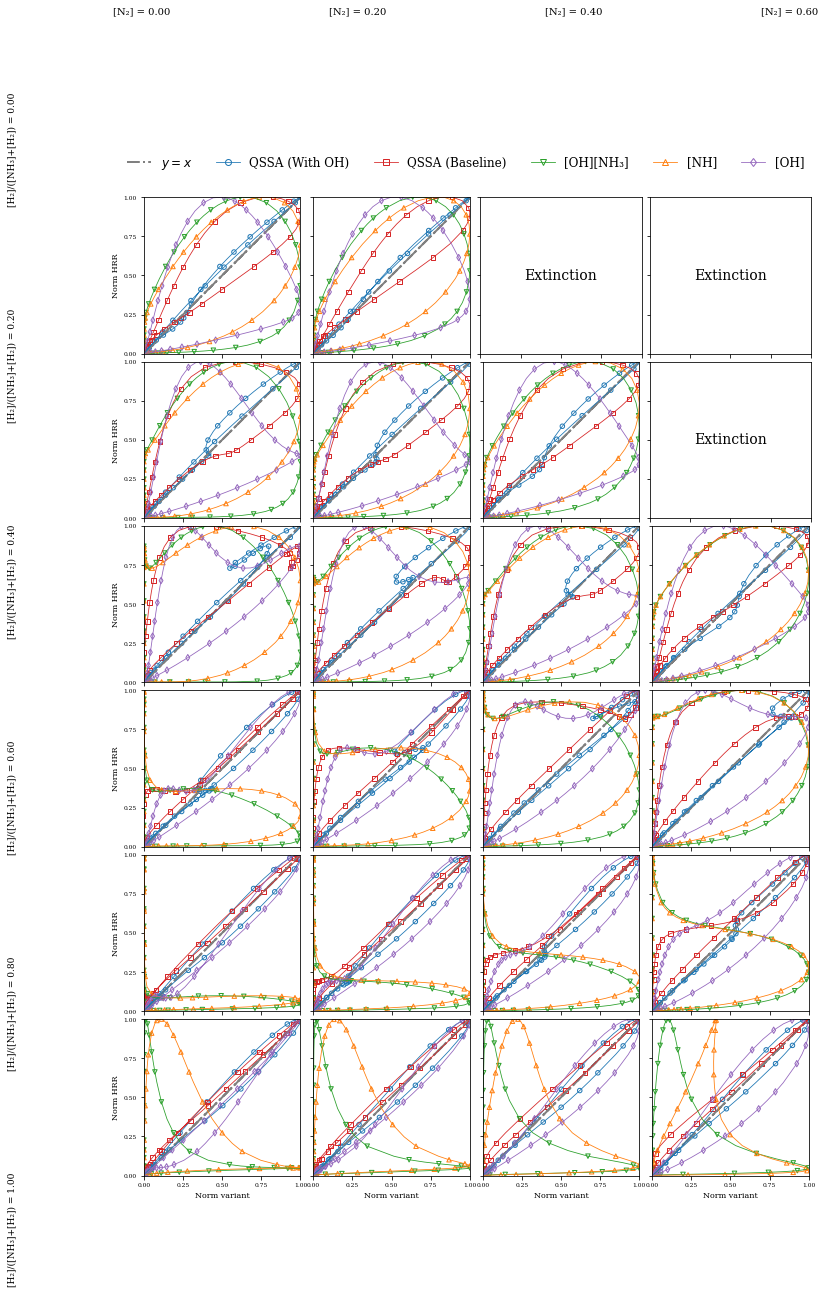

→ saved: figs/validation/Supplementary_HRR_grid_4cols_by_N2_nicer_titles.pdf


In [200]:
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ─── User‐adjustable settings ──────────────────────────────────────────────────
data_path           = "SIM_results"
row1_qssa_case_name = "case_NH3_counterflow_PCI_matrix"
row2_qssa_case_name = "case_NH3_counterflow_PCI_matrix_OH"
mech                = "Otomo_32s213r"

# ─── 1) manually list all cases ────────────────────────────────────────────────
all_cases = [
    # … your full list here as before …
    "N_CF_NH3_0.00_H2_0.40_N2_0.60", "N_CF_NH3_0.00_H2_0.60_N2_0.40",
    "N_CF_NH3_0.00_H2_0.80_N2_0.20", "N_CF_NH3_0.00_H2_1.00_N2_0.00",
    "N_CF_NH3_0.04_H2_0.36_N2_0.60", "N_CF_NH3_0.06_H2_0.54_N2_0.40",
    "N_CF_NH3_0.08_H2_0.32_N2_0.60", "N_CF_NH3_0.08_H2_0.72_N2_0.20",
    "N_CF_NH3_0.10_H2_0.90_N2_0.00", "N_CF_NH3_0.12_H2_0.28_N2_0.60",
    "N_CF_NH3_0.12_H2_0.48_N2_0.40", "N_CF_NH3_0.16_H2_0.24_N2_0.60",
    "N_CF_NH3_0.16_H2_0.64_N2_0.20", "N_CF_NH3_0.18_H2_0.42_N2_0.40",
    "N_CF_NH3_0.20_H2_0.20_N2_0.60", "N_CF_NH3_0.20_H2_0.80_N2_0.00",
    "N_CF_NH3_0.24_H2_0.16_N2_0.60", "N_CF_NH3_0.24_H2_0.36_N2_0.40",
    "N_CF_NH3_0.24_H2_0.56_N2_0.20", "N_CF_NH3_0.28_H2_0.12_N2_0.60",
    "N_CF_NH3_0.30_H2_0.30_N2_0.40", "N_CF_NH3_0.30_H2_0.70_N2_0.00",
    "N_CF_NH3_0.32_H2_0.08_N2_0.60", "N_CF_NH3_0.32_H2_0.48_N2_0.20",
    "N_CF_NH3_0.36_H2_0.04_N2_0.60", "N_CF_NH3_0.36_H2_0.24_N2_0.40",
    "N_CF_NH3_0.40_H2_0.00_N2_0.60", "N_CF_NH3_0.40_H2_0.40_N2_0.20",
    "N_CF_NH3_0.40_H2_0.60_N2_0.00", "N_CF_NH3_0.42_H2_0.18_N2_0.40",
    "N_CF_NH3_0.48_H2_0.12_N2_0.40", "N_CF_NH3_0.48_H2_0.32_N2_0.20",
    "N_CF_NH3_0.50_H2_0.50_N2_0.00", "N_CF_NH3_0.54_H2_0.06_N2_0.40",
    "N_CF_NH3_0.56_H2_0.24_N2_0.20", "N_CF_NH3_0.60_H2_0.00_N2_0.40",
    "N_CF_NH3_0.60_H2_0.40_N2_0.00", "N_CF_NH3_0.64_H2_0.16_N2_0.20",
    "N_CF_NH3_0.70_H2_0.30_N2_0.00", "N_CF_NH3_0.72_H2_0.08_N2_0.20",
    "N_CF_NH3_0.80_H2_0.00_N2_0.20", "N_CF_NH3_0.80_H2_0.20_N2_0.00",
    "N_CF_NH3_0.90_H2_0.10_N2_0.00", "N_CF_NH3_1.00_H2_0.00_N2_0.00"
]

# ─── 2) group & sort by H₂ within each N₂ ─────────────────────────────────────
def parse_fractions(c):
    m = re.match(r'.*NH3_([0-9.]+)_H2_([0-9.]+)_N2_([0-9.]+)', c)
    return float(m.group(1)), float(m.group(2)), float(m.group(3))

groups = {f"{v:.2f}": [] for v in [0.00, 0.20, 0.40, 0.60]}
for c in all_cases:
    _, h2, n2 = parse_fractions(c)
    key = f"{n2:.2f}"
    groups[key].append((h2, c))
for k in groups:
    groups[k].sort(key=lambda x: x[0])

# ─── 3) subsample every 2nd, flatten into 4‐column order ───────────────────────
fractions = ["0.00","0.20","0.40","0.60"]
sub = {f: groups[f][::2] for f in fractions}
n_cols = 4
n_rows = max(len(sub[f]) for f in fractions)
target_cases = []
h2_rows = []
for i in range(n_rows):
    # pick the H₂ ratio of the first column for this row
    h2_rows.append(sub[fractions[0]][i][0])
    for f in fractions:
        if i < len(sub[f]):
            _, case = sub[f][i]
            target_cases.append(case)

# ─── Plot‐style ────────────────────────────────────────────────────────────────
series_info = [
    # y = x reference, bold gray line
    ("$y = x$",        "-.",   "gray",      None),
    ("QSSA (With OH)",  "-",  "tab:blue",   "o"),
    ("QSSA (Baseline)", "-",  "tab:red",    "s"),
    ("[OH][NH₃]",       "-",  "tab:green",  "v"),
    ("[NH]",            "-",  "tab:orange","^"),
    ("[OH]",            "-",  "tab:purple","d"),
]

# ─── 4) build figure ───────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(3*n_cols, 3*n_rows),
    sharex=True, sharey=True,
    gridspec_kw={'hspace':0.05,'wspace':0.05}
)
axes = axes.flatten()

def plot_one(ax, case):
    # load SIM
    sim_csv = os.path.join(data_path, row1_qssa_case_name, mech, f"{case}.csv")
    df_sim = pd.read_csv(sim_csv)
    Tmax = df_sim["T"].max()
    if Tmax < 500:
        ax.text(0.5, 0.5, "Extinction",
                transform=ax.transAxes,
                ha='center', va='center',
                fontsize=14, color='black')
        ax.set_xticks([]); ax.set_yticks([])
        return

    simn = df_sim["HRR"] / df_sim["HRR"].max()
    q1 = pd.read_csv(os.path.join(
        "figs","QSSA",data_path,row1_qssa_case_name,case,mech,"predicted_X.csv"))
    q2 = pd.read_csv(os.path.join(
        "figs","QSSA",data_path,row2_qssa_case_name,case,mech,"predicted_X.csv"))

    variants = [
        (simn, simn),
        (q2["HRR"]/q2["HRR"].max(), simn),
        (q1["HRR"]/q1["HRR"].max(), simn),
        ((df_sim["X_OH"]*df_sim["X_NH3"]) /
         (df_sim["X_OH"]*df_sim["X_NH3"]).max(), simn),
        (df_sim["X_NH"]/df_sim["X_NH"].max(), simn),
        (df_sim["X_OH"]/df_sim["X_OH"].max(), simn),
    ]

    for (lbl, ls, col, mk), (x,y) in zip(series_info, variants):
        if mk is None:
            ax.plot(x, y, ls, color=col, linewidth=2)
        else:
            ax.plot(x, y, ls, color=col, linewidth=0.8)
            ax.scatter(x[::2], y[::2],
                       s=20, marker=mk,
                       facecolors='none', edgecolors=col)

    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_aspect('equal','box')
    ax.set_xticks([0,0.25,0.5,0.75,1])
    ax.set_yticks([0,0.25,0.5,0.75,1])

# ─ draw all subplots ────────────────────────────────────────────────────────────
for ax, case in zip(axes, target_cases):
    plot_one(ax, case)
for ax in axes[len(target_cases):]:
    ax.axis('off')

# ─── 5) add column headers (N₂) ────────────────────────────────────────────────
for j, frac in enumerate(fractions):
    x = (j + 0.5) / n_cols
    fig.text(x, 1.02, f"[N₂] = {frac}", ha='center', va='bottom', fontsize=10)

# ─── 6) add row labels (H₂ ratio) ─────────────────────────────────────────────
for i, h2 in enumerate(h2_rows):
    # normalized from top (i=0) to bottom
    y = 1 - (i + 0.5) / n_rows
    fig.text(-0.02, y, f"[H₂]/([NH₃]+[H₂]) = {h2:.2f}",
             ha='right', va='center', rotation='vertical', fontsize=9)

# ─── 7) frame‐wide legend ─────────────────────────────────────────────────────
proxy_h, proxy_l = [], []
for lbl, ls, col, mk in series_info:
    if mk is None:
        ph = Line2D([0],[0], ls=ls, color=col, linewidth=2)
    else:
        ph = Line2D([0],[0], ls=ls, color=col,
                    marker=mk, markerfacecolor='none',
                    markeredgecolor=col, markersize=6, linewidth=0.8)
    proxy_h.append(ph); proxy_l.append(lbl)

fig.legend(proxy_h, proxy_l,
           loc='upper center', ncol=len(proxy_h),
           frameon=False, fontsize=12,
           bbox_to_anchor=(0.5, 0.92))

# ─── 8) common x/y labels ─────────────────────────────────────────────────────
for idx, ax in enumerate(axes[:len(target_cases)]):
    col = idx % n_cols;   row = idx // n_cols
    if col == 0:
        ax.set_ylabel("Norm HRR", fontsize=8)
    else:
        ax.tick_params(labelleft=False)
    if row == n_rows - 1:
        ax.set_xlabel("Norm variant", fontsize=8)
    else:
        ax.tick_params(labelbottom=False)

fig.tight_layout(rect=[0,0,1,1])
os.makedirs("figs/validation", exist_ok=True)
fig.savefig("figs/validation/Supplementary_HRR_grid_4cols_by_N2_nicer_titles.pdf",
            dpi=300, bbox_inches='tight')
plt.show()
print("→ saved: figs/validation/Supplementary_HRR_grid_4cols_by_N2_nicer_titles.pdf")

# Compare Normalized Species

<ipython-input-10-7ecc056da776>:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.90])


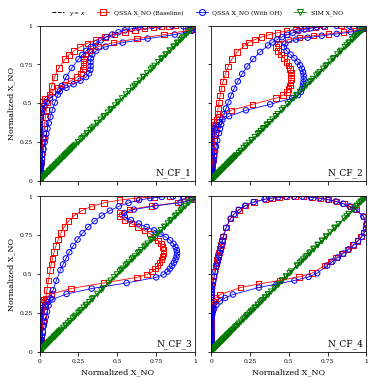

→ Saved X_NO comparison figure at: figs/validation/X_NO_comparison_2x2.pdf


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ─── User‐adjustable settings ──────────────────────────────────────────────────
data_path             = "SIM_results"
row1_qssa_case_name   = "case_NH3_counterflow_KAUST"
row2_qssa_case_name   = "case_NH3_counterflow_KAUST_OH"
target_cases          = ["N_CF_1", "N_CF_2", "N_CF_3", "N_CF_4"]
mech                  = "Otomo_32s213r"  # only Otomo here

# ─── Plot‐style arrays ─────────────────────────────────────────────────────────
# Each entry: (legend_label, linestyle, color, marker)
series_info = [
    # y = x reference
    ("$y = x$",             "--",  "k",  None),
    # QSSA X_NO from the “normal” folder
    ("QSSA X_NO (Baseline)", "-",   "r",  "s"),
    # QSSA X_NO from the “OH” folder
    ("QSSA X_NO (With OH)",  "-",   "b",  "o"),
    # SIM X_NO
    ("SIM X_NO",            "-",   "g",  "v"),
]

# ─── Create a 2×2 grid of subplots, sharing both X and Y, with small padding ──
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(3 * n_cols, 3 * n_rows),
    sharex=True,
    sharey=True,
    gridspec_kw={'hspace': 0.1, 'wspace': 0.05}
)
axes = axes.flatten()  # so we can index subplots by a single index

def plot_one_subplot(ax, target_case):
    # 1) Load SIM data
    sim_csv = os.path.join(data_path, row1_qssa_case_name, mech, f"{target_case}.csv")
    if not os.path.isfile(sim_csv):
        raise FileNotFoundError(f"Simulation file not found:\n{sim_csv}")
    df_sim = pd.read_csv(sim_csv)

    # 2) Load QSSA X_NO from “normal”
    qssa1_csv = os.path.join(
        "figs", "QSSA", data_path, row1_qssa_case_name, target_case, mech, "predicted_X.csv"
    )
    if not os.path.isfile(qssa1_csv):
        raise FileNotFoundError(f"QSSA (normal) file not found:\n{qssa1_csv}")
    df_qssa1 = pd.read_csv(qssa1_csv)

    # 3) Load QSSA X_NO from “OH”
    qssa2_csv = os.path.join(
        "figs", "QSSA", data_path, row2_qssa_case_name, target_case, mech, "predicted_X.csv"
    )
    if not os.path.isfile(qssa2_csv):
        raise FileNotFoundError(f"QSSA (OH) file not found:\n{qssa2_csv}")
    df_qssa2 = pd.read_csv(qssa2_csv)

    # 4) Prepare SIM X_NO (normalized)
    sim_x_no      = df_sim["X_NO"].to_numpy()
    sim_x_no_norm = sim_x_no / np.max(sim_x_no)

    # 5) Prepare QSSA X_NO (normalized)
    qssa1_x_no_norm = df_qssa1["X_NO"].to_numpy()
    qssa1_x_no_norm = qssa1_x_no_norm / np.max(qssa1_x_no_norm)
    qssa2_x_no_norm = df_qssa2["X_NO"].to_numpy()
    qssa2_x_no_norm = qssa2_x_no_norm / np.max(qssa2_x_no_norm)

    # 6) Build the (x, y) pairs in the same order as series_info
    variants = [
        (sim_x_no_norm, sim_x_no_norm),  # (a) y = x reference
        (qssa1_x_no_norm, sim_x_no_norm),# (b) QSSA1 X_NO vs SIM X_NO
        (qssa2_x_no_norm, sim_x_no_norm),# (c) QSSA2 X_NO vs SIM X_NO
        (sim_x_no_norm, sim_x_no_norm),  # (d) SIM X_NO vs SIM X_NO (for markers)
    ]

    # 7) Plot each series
    for (label, ls, color, marker), (x_arr, y_arr) in zip(series_info, variants):
        if marker is None:
            ax.plot(x_arr, y_arr, linestyle=ls, color=color, linewidth=1)
        else:
            ax.plot(x_arr, y_arr, linestyle=ls, color=color, linewidth=0.8)
            ax.scatter(
                x_arr,
                y_arr,
                s=30,
                marker=marker,
                facecolors='none',    # hollow marker
                edgecolors=color,
                label=label
            )

    # 8) Finalize axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')

    # Force ticks at 0, 0.25, 0.5, 0.75, and 1
    ticks = [0, 0.25, 0.5, 0.75, 1]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    # Only left‐column subplots get a y‐label and visible y‐tick labels
    idx = target_cases.index(target_case)
    col_index = idx % n_cols
    if col_index == 0:
        ax.set_ylabel("Normalized X_NO", fontsize=8)
        ax.tick_params(axis='y', labelsize=6, left=True, labelleft=True)
        ax.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])
    else:
        ax.tick_params(axis='y', labelleft=False)

    # Only bottom‐row subplots get an x‐label and visible x‐tick labels
    row_index = idx // n_cols
    if row_index == n_rows - 1:
        ax.set_xlabel("Normalized X_NO", fontsize=8)
        ax.tick_params(axis='x', labelsize=6, bottom=True, labelbottom=True)
        ax.set_xticklabels(['0', '0.25', '0.5', '0.75', '1'])
    else:
        ax.tick_params(axis='x', labelbottom=False)

    # Put the case name inside the axes (lower‐right corner)
    ax.text(
        0.98, 0.02,
        target_case,
        transform=ax.transAxes,
        ha='right', va='bottom',
        fontsize=9
    )

# ─── Draw all subplots ─────────────────────────────────────────────────────────
for idx_case, target_case in enumerate(target_cases):
    plot_one_subplot(axes[idx_case], target_case)

# ─── Build a single external legend and place it above the subplots ───────────
proxy_handles = []
proxy_labels  = []
for (label, ls, color, marker) in series_info:
    if marker is None:
        ph = Line2D([0], [0], linestyle=ls, color=color, linewidth=1)
    else:
        ph = Line2D(
            [0], [0],
            linestyle=ls, color=color, marker=marker,
            markerfacecolor='none', markeredgecolor=color,  # hollow in legend
            markersize=6, linewidth=0.8
        )
    proxy_handles.append(ph)
    proxy_labels.append(label)

# Move legend to top-center.
fig.legend(
    proxy_handles,
    proxy_labels,
    loc='upper center',
    ncol=len(proxy_handles),
    frameon=False,
    fontsize=6,
    bbox_to_anchor=(0.5, 0.93)
)

# ─── Use tight layout and leave room for the top legend ────────────────────────
fig.tight_layout(rect=[0, 0, 1, 0.90])

out_dir = "figs/validation"
os.makedirs(out_dir, exist_ok=True)
save_path = os.path.join(out_dir, "X_NO_comparison_2x2.pdf")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"→ Saved X_NO comparison figure at: {save_path}")

# Add the Pearson Correlation plot of different cases using Otomo

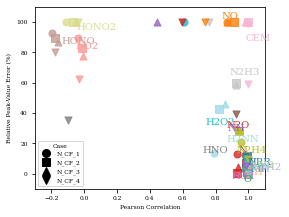

Scatter saved to figs/NH3_NP_CF/pearson_vs_peak_error_labels_OH.pdf


In [11]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

def plot_corr_vs_peak_error(sim_case_dir,
                            recon_case_dir,
                            mechanism,
                            fig_dir,
                            target_cases,
                            data_species,        # list of strings
                            pdf_name,
                            cmap_name='tab20',
                            min_peak_threshold=1e-6,
                            label_offsets=None):
    if label_offsets is None:
        label_offsets = {}

    # 1) load N_0 to threshold & order
    df_sim_N0   = pd.read_csv(Path(sim_case_dir) /mechanism/ "N_CF_1.csv")
    sp_peaks_N0 = {sp: df_sim_N0[sp].max() for sp in data_species}
    filtered    = [sp for sp in data_species
                   if sp_peaks_N0.get(sp, 0) >= min_peak_threshold]
    ordered_sp  = sorted(filtered,
                         key=lambda sp: sp_peaks_N0[sp],
                         reverse=True)

    # 2) build color & marker maps
    cases = target_cases
    cmap  = plt.get_cmap(cmap_name)
    species_colors = {sp: cmap(i / len(ordered_sp)) for i, sp in enumerate(ordered_sp)}
    marker_list = ['o','s','^','v','<','>','P','X','D','*','h','+','x','|','_']
    case_markers = {case: marker_list[i % len(marker_list)] for i, case in enumerate(cases)}

    # 3) collect data
    records = []
    for case in cases:
        df_sim   = pd.read_csv(Path(sim_case_dir) / mechanism /f"{case}.csv")
        recon_p  = Path(recon_case_dir) / case / mechanism / "predicted_X.csv"
        df_recon = pd.read_csv(recon_p) if recon_p.is_file() else None

        for sp in ordered_sp:
            tp = df_sim[sp].max()
            rp = df_recon[sp].max() if df_recon is not None else np.nan
            err = (abs(rp - tp)/abs(tp)*100) if tp!=0 else np.nan
            err = min(err,100)

            tvals = df_sim[sp].values
            rvals = df_recon[sp].values if df_recon is not None else np.full_like(tvals, np.nan)
            m = min(len(tvals), len(rvals))
            tvals, rvals = tvals[:m], rvals[:m]
            corr = pearsonr(tvals, rvals)[0] if m>1 and not np.isnan(tvals).any() and not np.isnan(rvals).any() else np.nan

            records.append((case, sp, corr, err))

    df = pd.DataFrame(records, columns=['case','species','corr','error'])

    # 4) plot
    fig, ax = plt.subplots(figsize=(4,3))
    species_centroids = {}

    for case, group in df.groupby('case'):
        for sp, sub in group.groupby('species'):
            ax.scatter(sub['corr'], sub['error'],
                       color=species_colors[sp],
                       marker=case_markers[case],
                       s=50, alpha=0.8)
            # accumulate centroids
            c = (sub['corr'].mean(), sub['error'].mean())
            species_centroids.setdefault(sp, []).append(c)

    # draw ellipses + inline labels
    for sp, pts in species_centroids.items():
        xs, ys = zip(*pts)
        xc, yc = np.mean(xs), np.mean(ys)
        w = (max(xs)-min(xs))*1  or 0.05
        h = (max(ys)-min(ys))*1.2 or 5.0

        color = species_colors[sp]

        dx, dy = label_offsets.get(sp, (-w/2, 0))
        # Remove the "X_" from the species name for better labeling
        sp_name = sp.replace("X_", "")  # Remove the "X_" prefix
        ax.text(xc+dx, yc+dy, sp_name,
                fontsize=10, color=color,
                ha='left', va='center', alpha=1)

    ax.set_xlabel('Pearson Correlation')
    ax.set_ylabel('Relative Peak‐Value Error (%)')
    ax.set_xlim(-0.3, 1.1)
    ax.set_ylim(-10, 110)

    # Case‐marker legend only
    case_handles = [
        Line2D([0],[0],
               marker=case_markers[c],
               color='k', linestyle='',
               markersize=8, label=c)
        for c in cases
    ]
    ax.legend(handles=case_handles,
              title='Case',
              bbox_to_anchor=(0,0),
              loc='lower left')

    plt.tight_layout()
    os.makedirs(fig_dir, exist_ok=True)
    outpath = Path(fig_dir) / pdf_name
    plt.savefig(outpath, format='pdf')
    plt.show()
    plt.close()
    print(f'Scatter saved to {outpath}')

plot_corr_vs_peak_error(
    sim_case_dir="SIM_results/case_NH3_counterflow_KAUST",
    recon_case_dir="figs/QSSA/SIM_results/case_NH3_counterflow_KAUST_OH",
    mechanism="Otomo_32s213r",
    fig_dir="figs/NH3_NP_CF",
    target_cases=["N_CF_1","N_CF_2","N_CF_3", "N_CF_4"],
    data_species=[
        "X_NO","X_H","X_O","X_OH","X_HO2","X_H2O2","X_NH2","X_NH","X_N","X_NNH","X_NH2OH",
        "X_H2NO","X_HNOH","X_HNO","X_HON","X_NO2","X_HONO","X_HNO2","X_NO3","X_HONO2",
        "X_N2O","X_N2H4","X_N2H3","X_N2H2","X_H2NN","MF","HRR", "CEM"
    ],
    pdf_name="pearson_vs_peak_error_labels_OH.pdf",
    cmap_name='tab20',
    min_peak_threshold=1e-6,
    label_offsets={
    'X_H':   (0.03,  0),
    'X_O':   (-0.03, -4),
    'X_OH':  (0.03,  3),
    'X_NO2':  (-0.03,  6),
    'X_N2O':  (0.02,  3),
    'X_HONO2':  (0.02,  -3),
    'X_N2H3':  (0,  5),
    'X_NH2':  (0.01,  5),
    'X_N2H2':  (0.02,  0),
    'X_NH':  (0.02,  0),
    'X_N2H4':  (-0.03,  -6),
    'X_H2NN':  (0,  -4),
    'X_HONO':  (0.04,  0),
    'X_NO':  (-0.01,  4),
    'Qdot':  (0.03,  4),
    'X_HO2':  (-0.1,  -4),
    'X_H2O2':  (-0.15,  4),
    'X_HNO':  (0,  6),
    'MF':  (0.01,  3),
}
)

# 做一个放大效果吧！

    label_offsets={
    'X_H':   (0.03,  0),
    'X_O':   (-0.03, -4),
    'X_OH':  (0.03,  3),
    'X_NO2':  (-0.03,  6),
    'X_N2O':  (0.02,  3),
    'X_HONO2':  (0.02,  -3),
    'X_N2H3':  (0,  5),
    'X_NH2':  (0.01,  5),
    'X_N2H2':  (0.02,  0),
    'X_NH':  (0.02,  0),
    'X_N2H4':  (-0.03,  -6),
    'X_H2NN':  (0,  -4),
    'X_HONO':  (0.04,  0),
    'X_NO':  (-0.01,  4),
    'Qdot':  (0.03,  4),
    'X_HO2':  (-0.1,  -4),
    'X_H2O2':  (-0.15,  4),
    'X_HNO':  (0,  6),
    'MF':  (0.01,  3),
}



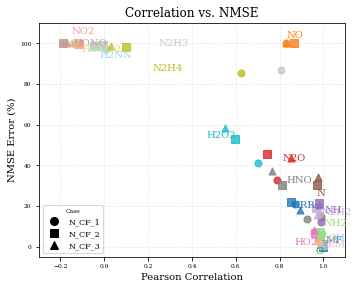

Scatter saved to figs/NH3_NP_CF/corr_vs_peak_error.pdf


In [12]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import re

def plot_corr_vs_peak_error(
    sim_case_dir: str,
    recon_case_dir: str,
    mechanism: str,
    fig_dir: str,
    target_cases: list,
    data_species: list,        # list of strings
    pdf_name: str,
    cmap_name: str = 'tab20',
    min_peak_threshold: float = 1e-6,
    label_offsets: dict = None,
    error_type: str = "peak"   # either "peak" or "nmse"
):
    """
    Plots, for each species:
      – Pearson correlation between SIM vs. QSSA time‐series (x‐axis)
      – either relative peak‐value error (%) or NMSE (%) (y‐axis)
      
    Parameters
    ----------
    sim_case_dir:    root folder where SIM CSVs live, e.g. "SIM_results/case_NH3_counterflow_KAUST"
    recon_case_dir:  root folder for QSSA CSVs, e.g. "figs/QSSA/SIM_results/case_NH3_counterflow_KAUST"
    mechanism:       name of mechanism subfolder (e.g. "Otomo_32s213r")
    fig_dir:         where to save the PDF
    target_cases:    list of case names, e.g. ["N_CF_1","N_CF_2","N_CF_3"]
    data_species:    list of species columns to include (strings)
    pdf_name:        output PDF filename (e.g. "pearson_vs_error.pdf")
    cmap_name:       name of a Matplotlib colormap for coloring species
    min_peak_threshold:
                     only include species whose peak in SIM N0 exceeds this
    label_offsets:   dict mapping species → (dx, dy) for text annotations
    error_type:      "peak" for relative peak‐value error (%),
                     "nmse" for normalized MSE (%) across the entire profile
    """
    if label_offsets is None:
        label_offsets = {}

    # 1) Load “N_CF_1.csv” (SIM) to decide which species pass the threshold
    df_sim_N0 = pd.read_csv(Path(sim_case_dir) / mechanism / "N_CF_1.csv")
    sp_peaks_N0 = {sp: df_sim_N0.get(sp, pd.Series([])).max() for sp in data_species}
    filtered    = [sp for sp in data_species if sp_peaks_N0.get(sp, 0) >= min_peak_threshold]
    ordered_sp  = sorted(filtered, key=lambda sp: sp_peaks_N0[sp], reverse=True)

    # 2) Build color & marker maps
    cmap  = plt.get_cmap(cmap_name)
    species_colors = {sp: cmap(i / len(ordered_sp)) for i, sp in enumerate(ordered_sp)}
    marker_list = ['o','s','^','v','<','>','P','X','D','*','h','+','x','|','_']
    case_markers = {case: marker_list[i % len(marker_list)] for i, case in enumerate(target_cases)}

    # 3) Collect Pearson r and error for each (case, species)
    records = []
    for case in target_cases:
        # 3a) Load SIM for this case
        sim_csv = Path(sim_case_dir) / mechanism / f"{case}.csv"
        if not sim_csv.is_file():
            raise FileNotFoundError(f"Simulation file not found:\n{sim_csv}")
        df_sim = pd.read_csv(sim_csv)

        # 3b) Load QSSA for this case
        recon_p = Path(recon_case_dir) / case / mechanism / "predicted_X.csv"
        df_recon = pd.read_csv(recon_p) if recon_p.is_file() else None

        for sp in ordered_sp:
            # 3c) Peak-based error:
            tvals = df_sim.get(sp, pd.Series([])).values
            rvals = df_recon.get(sp, pd.Series(np.nan * np.ones_like(tvals))).values if df_recon is not None else np.full_like(tvals, np.nan)

            # If either has no data, skip
            if tvals.size == 0 or rvals.size == 0:
                continue

            # 3d) Compute “peak” error if requested
            peak_sim = np.nanmax(tvals)
            peak_recon = np.nanmax(rvals)
            if error_type == "peak":
                if peak_sim == 0:
                    err = np.nan
                else:
                    err = abs(peak_recon - peak_sim) / abs(peak_sim) * 100.0
                    err = min(err, 100.0)

            # 3e) Compute NMSE if requested
            elif error_type == "nmse":
                # Truncate to equal length if necessary
                m = min(tvals.size, rvals.size)
                t_arr = tvals[:m]
                r_arr = rvals[:m]
                # If SIM is all zero, skip
                denom = np.nanmean(t_arr**2)
                if denom <= 0:
                    err = np.nan
                else:
                    mse = np.nanmean((r_arr - t_arr) ** 2)
                    nmse = mse / denom * 100.0
                    err = nmse
                    err = min(err, 100.0)
            else:
                raise ValueError("error_type must be either 'peak' or 'nmse'")

            # 3f) Compute Pearson r between t_arr and r_arr
            if tvals.size != rvals.size:
                m = min(tvals.size, rvals.size)
                t_arr = tvals[:m]
                r_arr = rvals[:m]
            else:
                t_arr = tvals
                r_arr = rvals

            if t_arr.size < 2 or np.all(np.isnan(t_arr)) or np.all(np.isnan(r_arr)):
                corr = np.nan
            else:
                # If constant, Pearson is undefined
                if np.nanstd(t_arr) == 0 or np.nanstd(r_arr) == 0:
                    corr = np.nan
                else:
                    corr = pearsonr(t_arr, r_arr)[0]

            records.append((case, sp, corr, err))

    df = pd.DataFrame(records, columns=['case', 'species', 'corr', 'error'])

    # 4) Plot
    fig, ax = plt.subplots(figsize=(5, 4))
    species_centroids = {}

    for case, group in df.groupby('case'):
        for sp, sub in group.groupby('species'):
            ax.scatter(
                sub['corr'], sub['error'],
                color=species_colors[sp],
                marker=case_markers[case],
                s=50, alpha=0.8
            )
            # accumulate centroids
            c = (sub['corr'].mean(), sub['error'].mean())
            species_centroids.setdefault(sp, []).append(c)

    # Draw (optional) ellipses around each species cluster, then label
    for sp, pts in species_centroids.items():
        xs, ys = zip(*pts)
        xc, yc = np.nanmean(xs), np.nanmean(ys)
        w = (np.nanmax(xs) - np.nanmin(xs)) * 1.0 or 0.05
        h = (np.nanmax(ys) - np.nanmin(ys)) * 1.2 or 5.0
        color = species_colors[sp]
        # If you want an ellipse, uncomment these two lines:
        # ell = Ellipse((xc, yc), w, h,
        #               edgecolor=color, facecolor='none', lw=1, alpha=0.6)
        # ax.add_patch(ell)

        dx, dy = label_offsets.get(sp, (-w/2, 0))
        sp_name = sp.replace("X_", "")
        ax.text(
            xc + dx, yc + dy, sp_name,
            fontsize=10, color=color,
            ha='left', va='center', alpha=1
        )

    # 5) Axes labels
    ax.set_xlabel("Pearson Correlation", fontsize=10)
    if error_type == "peak":
        ax.set_ylabel("Relative Peak‐Value Error (%)", fontsize=10)
        ax.set_ylim(-10, 110)
    else:  # nmse
        ax.set_ylabel("NMSE Error (%)", fontsize=10)
        ax.set_ylim(-5, np.nanmax(df['error']) * 1.1)

    ax.set_xlim(-0.3, 1.1)
    ax.set_title("Correlation vs. " + ("Peak Error" if error_type=="peak" else "NMSE"), fontsize=12)
    ax.grid(True, linestyle=":", alpha=0.5)

    # 6) Case‐marker legend (only markers for each case)
    case_handles = [
        Line2D(
            [0], [0],
            marker=case_markers[c],
            color='k', linestyle='',
            markersize=8, label=c
        )
        for c in target_cases
    ]
    ax.legend(
        handles=case_handles,
        title='Case',
        bbox_to_anchor=(0, 0),
        loc='lower left',
        fontsize=8
    )

    plt.tight_layout()
    os.makedirs(fig_dir, exist_ok=True)
    outpath = Path(fig_dir) / pdf_name
    plt.savefig(outpath, format='pdf')
    plt.show()
    plt.close()
    print(f"Scatter saved to {outpath}")


# ─── Example usage ─────────────────────────────────────────────────────────────
plot_corr_vs_peak_error(
    sim_case_dir    = "SIM_results/case_NH3_counterflow_KAUST",
    recon_case_dir  = "figs/QSSA/SIM_results/case_NH3_counterflow_KAUST",
    mechanism       = "Otomo_32s213r",
    fig_dir         = "figs/NH3_NP_CF",
    target_cases    = ["N_CF_1", "N_CF_2", "N_CF_3"],
    data_species    = [
        "X_NO","X_H","X_O","X_OH","X_HO2","X_H2O2","X_NH2","X_NH",
        "X_N","X_NNH","X_NH2OH","X_H2NO","X_HNOH","X_HNO","X_HON",
        "X_NO2","X_HONO","X_HNO2","X_NO3","X_HONO2","X_N2O","X_N2H4",
        "X_N2H3","X_N2H2","X_H2NN","MF","HRR","CEM"
    ],
    pdf_name        = "corr_vs_peak_error.pdf",
    cmap_name       = 'tab20',
    min_peak_threshold = 1e-6,
    label_offsets={
    'X_H':   (0.03,  0),
    'X_O':   (-0.03, -4),
    'X_OH':  (0.03,  3),
    'X_NO2':  (-0.03,  6),
    'X_N2O':  (0.02,  3),
    'X_HONO2':  (0.02,  -3),
    'X_N2H3':  (0,  5),
    'X_NH2':  (0.01,  5),
    'X_N2H2':  (0.02,  0),
    'X_NH':  (0.02,  0),
    'X_N2H4':  (-0.03,  -6),
    'X_H2NN':  (0,  -4),
    'X_HONO':  (0.04,  0),
    'X_NO':  (-0.01,  4),
    'Qdot':  (0.03,  4),
    'X_HO2':  (-0.1,  -4),
    'X_H2O2':  (-0.15,  4),
    'X_HNO':  (0,  6),
    'MF':  (0.01,  3),
},
    error_type = "nmse"   # "peak" or "nmse"
)

### Add the reaction path way analysis,(No Need)
### Add the time scale analysis (No Need)

# Figure 8: 完成不同掺氢比，掺氮气比的画图吧

<ipython-input-40-284736e123a4>:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig = cm.get_cmap("viridis_r")  # Original colormap


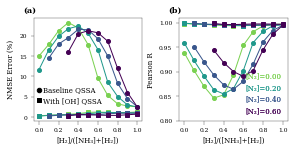

→ Saved combined subplot at: figs/validation/nmse_error_and_corr_vs_H2ratio.pdf


In [40]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams["xtick.labelsize"]  = 100   # ← increase x‐tick labels to 8pt
plt.rcParams["ytick.labelsize"]  = 100  # ← increase y‐tick labels to 8pt

def plot_error_and_corr_by_N2(
    base_sim_dir: str,
    base_qssa_dir: str,
    base_qssa_2_dir: str,
    mechanism: str,
    error_type: str = "peak",      # "peak" or "nmse"
    temp_threshold: float = 500.0,
    out_dir: str = "figs/validation"
):
    """
    Scan subfolders under `base_qssa_dir` & `_2_dir`, extract SIM vs QSSA,
    compute errors/correlations, and plot vs H2-ratio.
    """

    def parse_case_name(case_name: str):
        m = re.match(r".*NH3_([0-9.]+)_H2_([0-9.]+)_N2_([0-9.]+)", case_name)
        if not m:
            raise ValueError(f"Cannot parse fractions from '{case_name}'")
        return float(m.group(1)), float(m.group(2)), float(m.group(3))

    def list_valid_cases(qssa_root):
        if not os.path.isdir(qssa_root):
            return []
        return sorted(d for d in os.listdir(qssa_root)
                      if os.path.isdir(os.path.join(qssa_root, d)))

    def accumulate_metrics(qssa_root, case_list, errors_dict, corr_dict):
        for case_name in case_list:
            try:
                nh3, h2, n2 = parse_case_name(case_name)
            except ValueError:
                continue
            if nh3 + h2 == 0:
                continue
            h2_ratio = h2 / (nh3 + h2)

            sim_csv_path  = os.path.join(base_sim_dir,  mechanism, f"{case_name}.csv")
            qssa_csv_path = os.path.join(qssa_root, case_name, mechanism, "predicted_X.csv")
            if not (os.path.isfile(sim_csv_path) and os.path.isfile(qssa_csv_path)):
                continue

            df_sim  = pd.read_csv(sim_csv_path)
            df_qssa = pd.read_csv(qssa_csv_path)

            if "T" not in df_sim.columns or df_sim["T"].max() <= temp_threshold:
                continue
            if "HRR" not in df_sim.columns or "HRR" not in df_qssa.columns:
                continue

            sim_hrr_full  = df_sim["HRR"].to_numpy()
            qssa_hrr_full = df_qssa["HRR"].to_numpy()

            # Length mismatch if >2 points difference
            if abs(sim_hrr_full.size - qssa_hrr_full.size) > 2:
                print("⚠️ length mismatch", case_name,
                      sim_hrr_full.size, qssa_hrr_full.size)

            # Align
            if sim_hrr_full.size != qssa_hrr_full.size:
                nmin = min(sim_hrr_full.size, qssa_hrr_full.size)
                sim_arr  = sim_hrr_full[:nmin]
                qssa_arr = qssa_hrr_full[:nmin]
            else:
                sim_arr, qssa_arr = sim_hrr_full, qssa_hrr_full

            # Relative peak error
            peak_sim, peak_qssa = sim_arr.max(), qssa_arr.max()
            if peak_sim == 0:
                continue
            rel_peak_error = (peak_qssa - peak_sim)/peak_sim*100.0

            # NMSE
            denom = np.nanmean(sim_arr**2)
            if denom <= 0:
                nmse_error = np.nan
            else:
                mse = np.nanmean((qssa_arr - sim_arr)**2)
                nmse_error = mse/denom*100.0

                # Debug huge NMSE
                if error_type=="nmse" and not np.isnan(nmse_error) and nmse_error>1e6:
                    print("‼️ Very large NMSE detected:",
                          f"case={case_name}",
                          f"denom={denom:.3e}",
                          f"mse={mse:.3e}",
                          f"nmse%={nmse_error:.3e}")
                    print("  sim_arr[:5] =", sim_arr[:5])
                    print("  qssa_arr[:5]=", qssa_arr[:5])
                    plt.figure()
                    plt.plot(sim_arr, label="sim")
                    plt.plot(qssa_arr, label="qssa")
                    plt.title(f"Bad NMSE in {case_name}")
                    plt.legend()
                    plt.show()

            # Pearson R
            if sim_arr.size<2 or np.all(sim_arr==sim_arr[0]) or np.all(qssa_arr==qssa_arr[0]):
                continue
            pearson_r = np.corrcoef(sim_arr, qssa_arr)[0,1]

            chosen_error = rel_peak_error if error_type=="peak" else nmse_error
            errors_dict.setdefault(n2, []).append((h2_ratio, chosen_error))
            corr_dict.setdefault(n2, []).append((h2_ratio, pearson_r))

    # Gather cases
    cases1 = list_valid_cases(base_qssa_dir)
    cases2 = list_valid_cases(base_qssa_2_dir)

    # Pre-check mismatches
    for case_name in cases1:
        sim_path  = os.path.join(base_sim_dir,  mechanism, f"{case_name}.csv")
        qssa_path = os.path.join(base_qssa_dir, case_name, mechanism, "predicted_X.csv")
        if os.path.isfile(sim_path) and os.path.isfile(qssa_path):
            a = pd.read_csv(sim_path)["HRR"].size
            b = pd.read_csv(qssa_path)["HRR"].size
            if abs(a-b)>2:
                print("💥 Pre-check length mismatch", case_name, a, b)

    errors1_by_n2, corr1_by_n2 = {}, {}
    errors2_by_n2, corr2_by_n2 = {}, {}

    accumulate_metrics(base_qssa_dir,  cases1, errors1_by_n2, corr1_by_n2)
    accumulate_metrics(base_qssa_2_dir, cases2, errors2_by_n2, corr2_by_n2)

    # Collect N2 fractions
    unique_n2 = sorted(set(errors1_by_n2) | set(errors2_by_n2))
    if not unique_n2:
        print("No valid cases found; exiting.")
        return

    # Plot setup
    fig, (ax_err, ax_corr) = plt.subplots(1, 2, figsize=(4, 2), sharey=False)
    # cmap = plt.get_cmap("viridis")
    max_idx = max(1, len(unique_n2)-1)
    orig = cm.get_cmap("viridis_r")  # Original colormap
    # cmap = plt.get_cmap("Greens")   # or "tab20"
    greens_trunc = LinearSegmentedColormap.from_list(
    "GreensTrunc", orig(np.linspace(0.2, 1, 256))
)
    
    # Left: error
    for idx, n2 in enumerate(unique_n2):
        # color = cmap(idx/max_idx)
        cmap = greens_trunc
        normed = min(n2 / 0.6, 1.0)
        color  = cmap(normed)
        # Baseline: solid line + 'o' marker
        if n2 in errors1_by_n2:
            arr = np.array(errors1_by_n2[n2])
            h2, e = arr[:,0], arr[:,1]
            order = np.argsort(h2)
            ax_err.plot(h2[order], e[order],
                        linestyle='-', marker='o',
                        color=color, linewidth=1.0, markersize=4)
        # With OH: solid line + 's' marker
        if n2 in errors2_by_n2:
            arr = np.array(errors2_by_n2[n2])
            h2, e = arr[:,0], arr[:,1]
            order = np.argsort(h2)
            ax_err.plot(h2[order], e[order],
                        linestyle='-', marker='s',
                        color=color, linewidth=1.0, markersize=4)

    if error_type=="peak":
        ax_err.axhline(0, linestyle="--", linewidth=0.8, color="k")

    ax_err.set_xlabel("[H₂]/([NH₃]+[H₂])", fontsize=7)
    ax_err.set_ylabel(
        "Relative Peak-Value Error (%)" if error_type=="peak" else "NMSE Error (%)",
        fontsize=7
    )
    ax_err.tick_params(labelsize=6)

    # Right: Pearson R
    for idx, n2 in enumerate(unique_n2):
        color = cmap(idx/max_idx)
        # Baseline
        if n2 in corr1_by_n2:
            arr = np.array(corr1_by_n2[n2])
            h2, r = arr[:,0], arr[:,1]
            order = np.argsort(h2)
            ax_corr.plot(h2[order], r[order],
                         linestyle='-', marker='o',
                         color=color, linewidth=1.0, markersize=4)
        # With OH
        if n2 in corr2_by_n2:
            arr = np.array(corr2_by_n2[n2])
            h2, r = arr[:,0], arr[:,1]
            order = np.argsort(h2)
            ax_corr.plot(h2[order], r[order],
                         linestyle='-', marker='s',
                         color=color, linewidth=1.0, markersize=4)
    ax_corr.yaxis.set_major_locator(mticker.MaxNLocator(5))
    ax_corr.set_xlabel("[H₂]/([NH₃]+[H₂])", fontsize=7)
    ax_corr.set_ylabel("Pearson R", fontsize=7)
    ax_corr.set_ylim(0.8, 1.01)
    ax_corr.tick_params(labelsize=6)

    # # Color legend
    # handles, labels = [], []
    # for idx, n2 in enumerate(unique_n2):
    #     handles.append(Line2D([0],[0], color=cmap(idx/max_idx), linewidth=1.5))
    #     labels.append(f"[N₂]={n2:.2f}")
    # ncol = max(1, math.ceil(len(unique_n2)/4))
    # leg = ax_corr.legend(
    #     handles, labels, loc="lower right",
    #     frameon=False, ncol=ncol,
    #     fontsize=7, title_fontsize=7
    # )
        # Color‐only legend
    handles, labels = [], []
    for idx, n2 in enumerate(unique_n2):
        # create an invisible legend handle
        handles.append(Line2D([], [], linestyle='', marker='', color='none'))
        labels.append(f"[N₂]={n2:.2f}")

    ncol = max(1, math.ceil(len(unique_n2)/4))
    leg = ax_corr.legend(
        handles, labels,
        loc="lower right",
        frameon=False,
        ncol=ncol,
        fontsize=7,
        title_fontsize=7,
        handlelength=0,      # no line drawn
        handletextpad=0,     # no padding next to handle
    )
    # now color each text label
    for text, idx in zip(leg.get_texts(), range(len(unique_n2))):
        text.set_color(cmap(idx/max_idx))
    ax_corr.add_artist(leg)

    # Line-style labels
    # Baseline QSSA: circle marker
    ax_err.scatter(
        [0.05], [0.3],
        marker='o', color='k',
        transform=ax_err.transAxes,
        s=20, zorder=4
    )
    ax_err.text(
        0.08, 0.3, "Baseline QSSA",
        transform=ax_err.transAxes,
        fontsize=7, va="center", ha="left"
    )

    # With [OH] QSSA: square marker
    ax_err.scatter(
        [0.05], [0.2],
        marker='s', color='k',
        transform=ax_err.transAxes,
        s=20, zorder=4
    )
    ax_err.text(
        0.08, 0.2, "With [OH] QSSA",
        transform=ax_err.transAxes,
        fontsize=7, va="center", ha="left"
    )
    ax_err.text(-0.1, 1.05, "(a)", transform=ax_err.transAxes,
                fontsize=8, fontweight="bold")
    ax_corr.text(-0.1, 1.05, "(b)", transform=ax_corr.transAxes,
                fontsize=8, fontweight="bold")
    
    plt.tight_layout(pad=0.4)
    os.makedirs(out_dir, exist_ok=True)
    fname = "peak_error_and_corr_vs_H2ratio.pdf" if error_type=="peak" else "nmse_error_and_corr_vs_H2ratio.pdf"
    plt.savefig(os.path.join(out_dir, fname), dpi=300, bbox_inches="tight")
    plt.show()
    print(f"→ Saved combined subplot at: {os.path.join(out_dir, fname)}")


# Example usage
if __name__ == "__main__":
    plot_error_and_corr_by_N2(
        base_sim_dir="SIM_results/case_NH3_counterflow_PCI_matrix",
        base_qssa_dir="figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix",
        base_qssa_2_dir="figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix_OH",
        mechanism="Otomo_32s213r",
        error_type="nmse",      # "peak" or "nmse"
        temp_threshold=300.0,
        out_dir="figs/validation"
    )

# Figure 9:The flux distribution of different cases


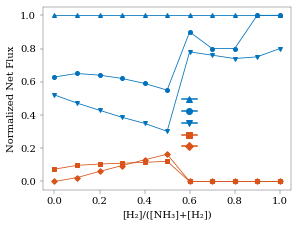

→ saved combined figure at: figs/reaction_flux/oh_fluxes_vs_H2ratio.pdf


In [47]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from typing import Tuple, List, Dict
plt.rcParams["xtick.labelsize"]  = 7   # ← increase x‐tick labels to 8pt
plt.rcParams["ytick.labelsize"]  = 7   # ← increase y‐tick labels to 8pt

# ── 1) utilities ──────────────────────────────────────────────────────────────
def parse_case_name(case_name: str) -> Tuple[float, float, float]:
    m = re.match(r'.*NH3_([0-9.]+)_H2_([0-9.]+)_N2_([0-9.]+)', case_name)
    if not m:
        raise ValueError(f"Bad case name '{case_name}'")
    return float(m.group(1)), float(m.group(2)), float(m.group(3))


def grab_net_flux(dot_path: str, src: str, dst: str) -> float:
    if not os.path.isfile(dot_path):
        return 0.0
    text = open(dot_path).read()
    edge_rx = re.compile(rf'{src}\s*->\s*{dst}\s*\[(.*?)\];', re.DOTALL)
    em = edge_rx.search(text)
    if not em:
        return 0.0
    body = em.group(1)
    fwd = re.search(rf'fwd:\s*([0-9.eE+-]+)', body)
    rev = re.search(rf'rev:\s*([0-9.eE+-]+)', body)
    if not fwd or not rev:
        return 0.0
    return float(fwd.group(1)) - float(rev.group(1))


# ── 2) plotting ────────────────────────────────────────────────────────────────
def plot_fluxes_N2_0p2(
    edges: List[Tuple[str, str]] = [
        ("s6","s9"), ("s5","s6"), ("s3","s6"), 
        ("s6","s18"), ("s6","s0")
    ],
    # edge_labels: List[str] = [
        # "OH + H₂ ⇄ H + H₂O (R4)",
        # "O + H₂ ⇄ OH + H (R2)",
        # "H + O₂ ⇄ O + OH (R1)",
        # "NH + OH ⇄ HNO + H (R57)",
        # "N + OH ⇄ NO + H (R68)",
    # ],
    edge_labels: List[str] = [
        " ",
        " ",
        " ",
        " ",
        " ",
    ],
    edge_colors: Tuple[str,...] = (
        "#0072BD",     # a brighter green
        "#0072BD",     # default matplotlib “green”
        "#0072BD",      # a darker green
        "#D95319",       # default matplotlib “red”
        "#D95319"      # a softer red
    ),
   symbols: Tuple[str,...] = ('^','o','v','s','D'),
    root_dir: str = "figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix_figure8",
    subdir: str = "Otomo_32s213r",
    dot_name: str = "O_rxnpath.dot",
    out_png: str = "figs/reaction_flux/oh_fluxes_vs_H2ratio.pdf"
):
    target_n2 = 0.20

    # gather data for N2 = 0.20
    data: Dict[Tuple[str,str], List[Tuple[float,float]]] = {}
    for case in sorted(os.listdir(root_dir)):
        case_dir = os.path.join(root_dir, case)
        if not os.path.isdir(case_dir):
            continue
        try:
            nh3, h2, n2 = parse_case_name(case)
        except ValueError:
            continue
        if abs(n2 - target_n2) > 1e-6:
            continue
        denom = nh3 + h2
        h2r = h2/denom if denom > 0 else 0.0
        dot_path = os.path.join(case_dir, subdir, dot_name)
        for e in edges:
            net = grab_net_flux(dot_path, *e)
            data.setdefault(e, []).append((h2r, net))

    # plot
    fig, ax = plt.subplots(figsize=(4,3))
    for i, edge in enumerate(edges):
        pts = np.array(data.get(edge, []))
        if pts.size == 0:
            continue
        order = np.argsort(pts[:,0])
        x = pts[:,0][order]
        y = pts[:,1][order]
        # clamp y to a maximum of 1
        y = np.minimum(y, 1.0)

        ax.plot(
            x, y,
            linestyle='-',
            color=edge_colors[i],
            marker=symbols[i],
            markersize=4,
            linewidth=0.8,
            label=edge_labels[i]
        )

    ax.set_xlabel("[H₂]/([NH₃]+[H₂])", fontsize=10)
    ax.set_ylabel("Normalized Net Flux", fontsize=10)
    # ax.tick_params(labelsize=8)
    ax.tick_params(axis="both", which="major", labelsize=10)
    # ax.grid(True, axis='y', alpha=0.2)

    # legend for reactions
    handles = [
        Line2D(
            [0], [0],
            color=edge_colors[i],
            marker=symbols[i],
            linestyle='-',
            markersize=6,
            label=edge_labels[i]
        )
        for i in range(len(edges))
    ]
    ax.legend(
        handles=handles,
        loc='upper right',
        bbox_to_anchor=(0.68, 0.55),   # x = 1.1 pushes right; y = 0.3 pushes down
        frameon=False,
        fontsize=7.5,
        title_fontsize=9
    )
    plt.tight_layout(pad=0.3)
    os.makedirs(os.path.dirname(out_png), exist_ok=True)
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("→ saved combined figure at:", out_png)


if __name__ == "__main__":
    plot_fluxes_N2_0p2()